# Week HW 18

Last Audit: HW18

# Import


In [2]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [3]:
#####################

salvage_value = 0
cost = 500
price = 1000
holding_cost = 0

model_prefix = f"linear_constraint_med_with_holding_cost_{holding_cost}"

#####################

data_size = 40
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 2000
MIPGAP = 0.1
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [4]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [5]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [6]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [7]:
show_models("linear_constraint_med_with_holding_cost")

Contents of models/linear_constraint_med_with_holding_cost_0_s2_100_202411271120.pkl:
{'alpha': array([1.22289394, 0.        , 3.96153466])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_200_202411271119.pkl:
{'alpha': array([ 69.77926805,   4.29391753, 124.0104279 ])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_20_202411272000.pkl:
{'alpha': array([1.65238988, 0.60126413, 4.06809387])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_40_202411271120.pkl:
{'alpha': array([0.88382231, 0.        , 9.78531581])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_40_202411271920.pkl:
{'alpha': array([0.88382231, 0.        , 9.78531581])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_50_202411271119.pkl:
{'alpha': array([275257.34539944,  29965.43240897, 515228.66545612])}

Contents of models/linear_constraint_med_with_holding_cost_0_s2_50_202411271920.pkl:
{'alpha': array([275257.34539944,  29965.43240

## Visualization 

In [7]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [8]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [10]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [11]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [12]:
def organize_stimulation_result(stimulation_df, Q_star, Qk_hat_df_train):

    # 檢查運算正確
    if stimulation_df is None or len(stimulation_df) == 0:
        return None, None

    Qk_hat_list = []
    for index, row in stimulation_df.iterrows():
        Qk_hat_list.append(Qk_hat_df_train.iloc[index, int(row["R"])])

    stimulation_df["Q_star"] = Q_star
    stimulation_df["Qk_hat"] = Qk_hat_list
    stimulation_df["Qk_hat-Q0"] = stimulation_df["Qk_hat"] - stimulation_df["Q0"]

    stimulation_df_selected = stimulation_df[
        [
            "R",
            "Q_star",
            "F",
            "Q0",
            "demand_up",
            "Sold0s",
            "Left0s",
            "lost0s",
            "Qk_hat",
            "Qk_hat-Q0",
            "Q1",
            "Q1_plus_lefts",
            "demand_down",
            "Sold1s",
            "Left1s",
            "lost1s",
        ]
    ]
    stimulation_df_selected["Q0-Sold0s(left0)"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    )
    stimulation_df_selected["demand_up-Q0(lost0)"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    )
    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    )

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    )

    stimulation_df_selected["Q0-Sold0s(left0)_clip"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_up-Q0(lost0)_clip"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    ).clip(lower=0)

    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    ).clip(lower=0)

    results = {
        "Metric": [
            "Left0s - Q0-Sold0s(left0)",
            "Lost0s - demand_up-Q0(lost0)",
            "Left1s - Q1_plus_lefts-Sold1s(left1)",
            "Lost1s - demand_down-Q1_plus_lefts(lost1)",
        ],
        "Average Difference": [
            round(
                (
                    stimulation_df_selected["Left0s"]
                    - (stimulation_df_selected["Q0-Sold0s(left0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost0s"]
                    - (stimulation_df_selected["demand_up-Q0(lost0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["Left1s"]
                    - (stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost1s"]
                    - (stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"])
                ).mean(),
                3,
            ),
        ],
    }

    return stimulation_df_selected, pd.DataFrame(results)

In [13]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [14]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [15]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [16]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    all_Qk_hat,
    all_sold0s,
    all_sold1s,
    all_demand_up,
    all_demand_down,
    all_Q1_plus_lefts,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
        "Qk_hat": all_Qk_hat,
        "Sold0s": all_sold0s,
        "Sold1s": all_sold1s,
        "demand_up": all_demand_up,
        "demand_down": all_demand_down,
        "Q1_plus_lefts": all_Q1_plus_lefts,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [17]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(100, 150, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
    }
)

full_df

X1         X2
0   127.440675 -22.809842
1   135.759468 -21.259361
2   130.138169 -16.047376
3   127.244159 -28.795491
4   121.182740 -16.664666
5   132.294706 -16.587243
6   121.879361 -25.792349
7   144.588650 -27.421474
8   148.183138 -23.691433
9   119.172076 -22.725785
10  139.586252 -18.596065
11  126.444746 -21.227970
12  128.402228 -10.232523
13  146.279832 -27.959104
14  103.551803 -25.822465
15  104.356465 -26.773810
16  101.010920 -16.937833
17  141.630992 -24.934168
18  138.907838 -20.673785
19  143.500607 -25.111488
20  148.930917 -26.820608
21  139.957928 -27.792497
22  123.073968 -16.873408
23  139.026459 -27.236341
24  105.913721 -26.068353
25  131.996051 -22.625497
26  107.167664 -13.580135
27  147.233446 -28.057974
28  126.092416 -13.241102
29  120.733097 -28.078032
30  113.227781 -10.470811
31  138.711684 -20.626976
32  122.807517 -10.464778
33  128.421697 -17.903090
34  100.939490 -15.214728
35  130.881775 -29.216244
36  130.604786 -24.343861
37  130.846700 -27.596069
38  147.187404 -24.077196
39  134.091015 -27.625446

In [18]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (20, 2), Test size: (20, 2)
Train (normalized):
         X1        X2
0  1.237600 -0.997816
1  0.171371  1.028775
2  0.883171 -0.458739
3 -2.019994 -0.617043
4 -0.123908  0.794276
Test (normalized):
         X1        X2
0 -0.531620  0.977777
1  1.439719 -0.794923
2  0.148601 -0.047309
3 -0.675808  1.014977
4  0.727280  0.670780

Fold 2:
Train size: (20, 2), Test size: (20, 2)
Train (normalized):
         X1        X2
0  0.650461 -0.967532
1 -1.493016 -0.719153
2 -1.815011  1.588922
3  1.291603 -0.879124
4  0.642782  0.428027
Test (normalized):
         X1        X2
0  0.075098  1.411856
1  0.630085  0.437982
2 -0.112239 -1.299092
3  0.710758 -1.085801
4  1.181722 -1.142256



## Data2: demand_df


### mu of each time(t)


In [20]:
# 設定 b0, b1, b2
b0 = 0.3
b1 = 0.17
b2 = 0.2


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 * random_noises[t - 1]
        )

    return mu_matrix

In [21]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (40, 10)
mu_matrix[0]: 
[17.63216209 17.22299355 17.39656778 17.77521435 17.66321378 16.80976302
 17.38797291 17.05753922 17.07198073 17.22612594]


### sigma matrix


In [22]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.17147401 -0.87170501  0.38494424  0.13320291 -0.46922102  0.04649611
  -0.81211898  0.15189299  0.8585924  -0.3628621 ]
 [ 0.33482076 -0.73640428  0.43265441 -0.42118781 -0.63361728  0.17302587
  -0.95978491  0.65788006 -0.99060905  0.35563307]]


In [23]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((40, 10),
 array([[6.68177369, 5.16225475, 7.31845273, 6.47705147, 5.66613443,
         6.80046065, 5.07168866, 7.23415131, 6.85283019, 6.49089789],
        [6.67677711, 4.7850146 , 7.48953405, 6.45635627, 5.41520143,
         6.84097849, 4.68599893, 7.37050483, 6.9780041 , 6.4261587 ],
        [6.88170151, 4.61705273, 7.60763506, 6.20868886, 5.19728908,
         6.91685245, 4.41041133, 7.63546181, 6.28836181, 6.68782553],
        [6.4870013 , 5.59866588, 7.08011494, 6.72238311, 6.04830293,
         6.70019126, 5.63634631, 6.8667742 , 7.39168905, 6.28289471],
        [6.92038981, 4.94116829, 7.46738178, 6.18702596, 5.39804789,
         6.89091203, 4.71509526, 7.55556463, 6.04244806, 6.79215188],
        [6.85037497, 4.58594638, 7.61588437, 6.24280842, 5.19127461,
         6.91180069, 4.3950806 , 7.61675192, 6.4149083 , 6.63871431],
        [6.62169769, 5.56494696, 7.12384868, 6.5713863 , 5.95871354,
         6.74081309, 5.52364781, 7.022523  , 6.95196126, 6.46591237],
        [6.41497

### corr matrix


In [24]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [25]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (40, 10, 10)
cov_matrices: 
[[ 44.64609963  12.21890295  27.1779542   25.4220707  -14.68104529
   -7.33770628  -3.35736682 -13.3382782  -22.38587203  -0.90751889]
 [ 12.21890295  26.64887407  24.39328077  11.51036888 -15.61841256
   -4.16755252  -9.59810611   2.69740107   3.88988613  -1.64610878]
 [ 27.1779542   24.39328077  53.55975037  12.31162535 -17.7684082
  -11.77135005 -20.47158162   0.5592107  -20.7753175   -6.1140927 ]
 [ 25.4220707   11.51036888  12.31162535  41.95219578 -15.9172934
   -3.47801518   5.46067497 -29.56712737   3.95654224  10.2656546 ]
 [-14.68104529 -15.61841256 -17.7684082  -15.9172934   32.10507935
   14.31086832   8.62997913  12.05177107  -5.96877497  -3.99223186]
 [ -7.33770628  -4.16755252 -11.77135005  -3.47801518  14.31086832
   46.24626511  22.70436146  25.60666479 -15.92579987   6.50722251]
 [ -3.35736682  -9.59810611 -20.47158162   5.46067497   8.62997913
   22.70436146  25.72202586   1.42873433  -0.33962805  15.99476004]
 [-13.338

In [26]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [27]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   15.641067  -0.158686   4.204498  11.098972  26.237237  24.488017   
1   20.667128  16.073384  25.332666  18.332350  20.092191  26.626114   
2   40.349247  23.891626  33.666427  28.287839   8.204571   6.669466   
3   14.732708  23.170461  18.589108  11.764030  14.924217  17.041043   
4   22.203155  16.539380  12.525311  19.910934  19.028863   5.386578   
5   21.826520  24.769591  30.066759  19.763461  15.596521  13.925413   
6   10.881937  20.501587  24.033118  16.111939   6.852948  10.019411   
7   20.921269  19.312925  14.466129  20.227496  19.072178  26.496593   
8   26.234768  23.873773  37.968736  24.828812  19.377617  19.682541   
9   22.273092  13.482696  21.452066  18.982042  20.265775  18.060486   
10   0.759442  14.630763   6.201818  15.864690  32.290726  19.751329   
11   6.528274   7.401129   9.482329   7.517564  30.773868  24.541131   
12  18.431624  19.028227  10.185779  22.924712  23.729863  22.388853   
13  24.960222  20.692981  27.303691  19.653523  20.545067  13.497153   
14  23.045823   9.920581  25.722114  18.860021  11.619067   2.476654   
15  12.588876  18.485443  16.524219   2.769528  11.621804  10.007638   
16  21.131018  26.272331  24.122865  14.242817  16.475955  21.757596   
17  16.998202  20.773882  15.397326  20.975344  24.749545  29.382531   
18  20.621332  26.155158  17.737454  19.174588  11.517567   8.415680   
19  24.135266  26.260611  30.930598  24.066301  12.081874  13.730776   
20  24.854172  18.754070  15.580757  27.653634  14.752467  22.933670   
21  14.563702  18.995893  13.551105  18.923430  20.214495  26.521256   
22  19.685537  22.204847  21.091220  23.113495  14.130586  15.354344   
23  18.252477  21.137754  26.780415  28.600846  13.811882  12.807092   
24  16.899361  15.694078  10.053696  16.870683   3.743127   9.233244   
25  16.823387  15.293604  13.588004  18.570383  22.598066  17.515924   
26  15.705301  22.439508  20.299749  22.316268   9.027436  11.811532   
27  19.894873  15.247163   3.119679  30.706344  18.218145  17.654457   
28  23.029999  18.903451  21.999218  16.701801  27.097977  19.599419   
29  22.686542  20.580650  19.047231  30.125564  13.585807  21.245002   
30  29.375034  23.637739  31.244805  20.154228  15.503052  11.970255   
31  18.842989  23.430890  27.384213  14.706323  19.300732  18.560900   
32  19.586905  26.894048  20.479556  22.958889  13.805832  14.441914   
33  10.914690  27.517686  10.442886  24.735531  20.915392  24.761943   
34   3.999698  13.863220   6.257547   8.998260  15.776101  13.089689   
35  15.657551  20.537813  18.217170  28.840084   7.309558  17.770809   
36  17.697115  13.422689  12.646816  19.250286  21.823409  23.539707   
37  17.036042  18.664777  11.679791  20.394613  19.040591  16.461127   
38  27.515243  28.290409  32.427143  19.449107   9.567185   5.590327   
39  14.498904  23.379048  14.704218  11.548260  14.952239  19.065195   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   26.877362  17.015780   5.233568   19.428233  
1   22.009440  24.072994   7.793132   20.698173  
2   15.486836  16.259831  10.908095   26.514941  
3    9.832421  28.533931  21.497860   17.237282  
4   13.000721  -0.975722  20.009844    2.463060  
5   14.491612  20.260512  20.558662   19.884258  
6    9.656692  17.859770  21.404270   19.883269  
7   24.502673  27.572508  21.058272   28.018312  
8   17.926867  22.781561  14.307078   31.543122  
9   12.348969  17.181314   5.602441   11.323945  
10  20.336186  17.483850  28.529110   13.823890  
11  19.556810  20.745034   8.388338    7.244937  
12  26.538393  11.369349  21.500766   17.384842  
13  14.896149  20.487059  15.555696   16.855662  
14   4.836026   8.967788   4.624307   15.633218  
15   7.392849  23.066888   8.661860    5.418260  
16  14.234621  21.272159   7.600592    9.279834  
17  22.923089  26.180948  21.285012   21.617180  
18  14.765166  22.005996  34.011193   28.100585  
19  17.767063  19.798836  16.417235   23.819743  
2

### Replace negative values to 0


In [28]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   15.641067   0.000000   4.204498  11.098972  26.237237  24.488017   
1   20.667128  16.073384  25.332666  18.332350  20.092191  26.626114   
2   40.349247  23.891626  33.666427  28.287839   8.204571   6.669466   
3   14.732708  23.170461  18.589108  11.764030  14.924217  17.041043   
4   22.203155  16.539380  12.525311  19.910934  19.028863   5.386578   
5   21.826520  24.769591  30.066759  19.763461  15.596521  13.925413   
6   10.881937  20.501587  24.033118  16.111939   6.852948  10.019411   
7   20.921269  19.312925  14.466129  20.227496  19.072178  26.496593   
8   26.234768  23.873773  37.968736  24.828812  19.377617  19.682541   
9   22.273092  13.482696  21.452066  18.982042  20.265775  18.060486   
10   0.759442  14.630763   6.201818  15.864690  32.290726  19.751329   
11   6.528274   7.401129   9.482329   7.517564  30.773868  24.541131   
12  18.431624  19.028227  10.185779  22.924712  23.729863  22.388853   
13  24.960222  20.692981  27.303691  19.653523  20.545067  13.497153   
14  23.045823   9.920581  25.722114  18.860021  11.619067   2.476654   
15  12.588876  18.485443  16.524219   2.769528  11.621804  10.007638   
16  21.131018  26.272331  24.122865  14.242817  16.475955  21.757596   
17  16.998202  20.773882  15.397326  20.975344  24.749545  29.382531   
18  20.621332  26.155158  17.737454  19.174588  11.517567   8.415680   
19  24.135266  26.260611  30.930598  24.066301  12.081874  13.730776   
20  24.854172  18.754070  15.580757  27.653634  14.752467  22.933670   
21  14.563702  18.995893  13.551105  18.923430  20.214495  26.521256   
22  19.685537  22.204847  21.091220  23.113495  14.130586  15.354344   
23  18.252477  21.137754  26.780415  28.600846  13.811882  12.807092   
24  16.899361  15.694078  10.053696  16.870683   3.743127   9.233244   
25  16.823387  15.293604  13.588004  18.570383  22.598066  17.515924   
26  15.705301  22.439508  20.299749  22.316268   9.027436  11.811532   
27  19.894873  15.247163   3.119679  30.706344  18.218145  17.654457   
28  23.029999  18.903451  21.999218  16.701801  27.097977  19.599419   
29  22.686542  20.580650  19.047231  30.125564  13.585807  21.245002   
30  29.375034  23.637739  31.244805  20.154228  15.503052  11.970255   
31  18.842989  23.430890  27.384213  14.706323  19.300732  18.560900   
32  19.586905  26.894048  20.479556  22.958889  13.805832  14.441914   
33  10.914690  27.517686  10.442886  24.735531  20.915392  24.761943   
34   3.999698  13.863220   6.257547   8.998260  15.776101  13.089689   
35  15.657551  20.537813  18.217170  28.840084   7.309558  17.770809   
36  17.697115  13.422689  12.646816  19.250286  21.823409  23.539707   
37  17.036042  18.664777  11.679791  20.394613  19.040591  16.461127   
38  27.515243  28.290409  32.427143  19.449107   9.567185   5.590327   
39  14.498904  23.379048  14.704218  11.548260  14.952239  19.065195   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   26.877362  17.015780   5.233568   19.428233  
1   22.009440  24.072994   7.793132   20.698173  
2   15.486836  16.259831  10.908095   26.514941  
3    9.832421  28.533931  21.497860   17.237282  
4   13.000721   0.000000  20.009844    2.463060  
5   14.491612  20.260512  20.558662   19.884258  
6    9.656692  17.859770  21.404270   19.883269  
7   24.502673  27.572508  21.058272   28.018312  
8   17.926867  22.781561  14.307078   31.543122  
9   12.348969  17.181314   5.602441   11.323945  
10  20.336186  17.483850  28.529110   13.823890  
11  19.556810  20.745034   8.388338    7.244937  
12  26.538393  11.369349  21.500766   17.384842  
13  14.896149  20.487059  15.555696   16.855662  
14   4.836026   8.967788   4.624307   15.633218  
15   7.392849  23.066888   8.661860    5.418260  
16  14.234621  21.272159   7.600592    9.279834  
17  22.923089  26.180948  21.285012   21.617180  
18  14.765166  22.005996  34.011193   28.100585  
19  17.767063  19.798836  16.417235   23.819743  
2

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [29]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0         173.243533      150.224732        20.973799       9.130128   
1         190.486444      201.697572        20.703420       5.107149   
2         191.354204      210.238880        20.845736      10.726195   
3         160.938159      177.323061        21.096569       5.261145   
4         174.895396      131.067847        21.113801       7.540384   
5         193.940584      201.143309        20.783607       4.630086   
6         157.824285      157.204941        21.203070       5.635950   
7         193.171826      221.648355        20.525998       4.137970   
8         206.742538      238.524875        20.370491       6.556149   
9         159.355029      160.972828        21.235879       5.013523   
10        202.318569      169.671805        20.579735       8.848708   
11        174.714198      142.179413        20.984882       8.410122   
12        200.032811      193.482407        20.929233       4.999777   
13        194.971576      194.447202        20.485704       4.171018   
14        126.607205      125.705600        21.813086       7.598633   
15        126.072441      116.537366        21.806563       5.908941   
16        140.056966      176.389787        21.764424       5.950240   
17        193.118420      220.283059        20.573045       3.901416   
18        197.009824      202.504720        20.607596       7.368539   
19        195.942126      209.008303        20.520747       5.644878   
20        201.755412      199.290633        20.388807       4.312957   
21        184.557553      199.478919        20.672832       4.157886   
22        177.692999      168.618241        21.056708       4.725313   
23        184.086368      172.160820        20.690267       6.468268   
24        130.130690      122.112324        21.738752       3.871707   
25        181.356363      187.184585        20.830691       3.268109   
26        157.238828      146.442288        21.544492       5.818153   
27        196.394978      206.014576        20.459352      10.490938   
28        190.088973      183.440770        20.969598       5.336746   
29        151.304271      208.688083        21.291478       4.916130   
30        173.759675      194.991382        21.361648       7.084178   
31        196.769981      194.589977        20.612909       4.730272   
32        190.057291      197.162260        21.082330       4.750945   
33        184.724776      215.352790        20.899425       6.544209   
34        143.381746      132.166730        21.753614       5.184178   
35        166.280598      185.649486        20.989726       6.813248   
36        175.554484      186.730436        20.898287       3.492999   
37        169.461322      186.731239        20.953002       3.925808   
38        204.278264      186.830207        20.402248       9.152650   
39        174.917904      186.698503        20.851166       4.421117   

    std_relative_error  
0           129.720768  
1           305.381190  
2            94.344184  
3           300.988161  
4           180.009613  
5           348.881646  
6           276.211103  
7           396.040323  
8           210.708197  
9           323.571966  
10          132.573330  
11          149.519365  
12          318.603336  
13          391.143945  
14          187.065919  
15          269.043527  
16          265.773875  
17          427.322450  
18          179.670022  
19          263.528603  
20          372.733843  
21          397.195777  
22          345.615084  
23          219.873376  
24          461.477275  
25          537.392770  
26          270.297812  
27           95.019279  
28          292.928570  
29          333.094306  
30          201.540252  
31          335.765826  
32          343.750254  
33          219.357568  
34          319.615506  
35          208.072241  
36          498.290618  
37          433.724650  
38          122.910823  
39          371.626618

### Validate normal distribution


In [30]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   15.641067   0.000000   4.204498  11.098972  26.237237  24.488017   
1   20.667128  16.073384  25.332666  18.332350  20.092191  26.626114   
2   40.349247  23.891626  33.666427  28.287839   8.204571   6.669466   
3   14.732708  23.170461  18.589108  11.764030  14.924217  17.041043   
4   22.203155  16.539380  12.525311  19.910934  19.028863   5.386578   
5   21.826520  24.769591  30.066759  19.763461  15.596521  13.925413   
6   10.881937  20.501587  24.033118  16.111939   6.852948  10.019411   
7   20.921269  19.312925  14.466129  20.227496  19.072178  26.496593   
8   26.234768  23.873773  37.968736  24.828812  19.377617  19.682541   
9   22.273092  13.482696  21.452066  18.982042  20.265775  18.060486   
10   0.759442  14.630763   6.201818  15.864690  32.290726  19.751329   
11   6.528274   7.401129   9.482329   7.517564  30.773868  24.541131   
12  18.431624  19.028227  10.185779  22.924712  23.729863  22.388853   
13  24.960222  20.692981  27.303691  19.653523  20.545067  13.497153   
14  23.045823   9.920581  25.722114  18.860021  11.619067   2.476654   
15  12.588876  18.485443  16.524219   2.769528  11.621804  10.007638   
16  21.131018  26.272331  24.122865  14.242817  16.475955  21.757596   
17  16.998202  20.773882  15.397326  20.975344  24.749545  29.382531   
18  20.621332  26.155158  17.737454  19.174588  11.517567   8.415680   
19  24.135266  26.260611  30.930598  24.066301  12.081874  13.730776   
20  24.854172  18.754070  15.580757  27.653634  14.752467  22.933670   
21  14.563702  18.995893  13.551105  18.923430  20.214495  26.521256   
22  19.685537  22.204847  21.091220  23.113495  14.130586  15.354344   
23  18.252477  21.137754  26.780415  28.600846  13.811882  12.807092   
24  16.899361  15.694078  10.053696  16.870683   3.743127   9.233244   
25  16.823387  15.293604  13.588004  18.570383  22.598066  17.515924   
26  15.705301  22.439508  20.299749  22.316268   9.027436  11.811532   
27  19.894873  15.247163   3.119679  30.706344  18.218145  17.654457   
28  23.029999  18.903451  21.999218  16.701801  27.097977  19.599419   
29  22.686542  20.580650  19.047231  30.125564  13.585807  21.245002   
30  29.375034  23.637739  31.244805  20.154228  15.503052  11.970255   
31  18.842989  23.430890  27.384213  14.706323  19.300732  18.560900   
32  19.586905  26.894048  20.479556  22.958889  13.805832  14.441914   
33  10.914690  27.517686  10.442886  24.735531  20.915392  24.761943   
34   3.999698  13.863220   6.257547   8.998260  15.776101  13.089689   
35  15.657551  20.537813  18.217170  28.840084   7.309558  17.770809   
36  17.697115  13.422689  12.646816  19.250286  21.823409  23.539707   
37  17.036042  18.664777  11.679791  20.394613  19.040591  16.461127   
38  27.515243  28.290409  32.427143  19.449107   9.567185   5.590327   
39  14.498904  23.379048  14.704218  11.548260  14.952239  19.065195   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   26.877362  17.015780   5.233568   19.428233  
1   22.009440  24.072994   7.793132   20.698173  
2   15.486836  16.259831  10.908095   26.514941  
3    9.832421  28.533931  21.497860   17.237282  
4   13.000721   0.000000  20.009844    2.463060  
5   14.491612  20.260512  20.558662   19.884258  
6    9.656692  17.859770  21.404270   19.883269  
7   24.502673  27.572508  21.058272   28.018312  
8   17.926867  22.781561  14.307078   31.543122  
9   12.348969  17.181314   5.602441   11.323945  
10  20.336186  17.483850  28.529110   13.823890  
11  19.556810  20.745034   8.388338    7.244937  
12  26.538393  11.369349  21.500766   17.384842  
13  14.896149  20.487059  15.555696   16.855662  
14   4.836026   8.967788   4.624307   15.633218  
15   7.392849  23.066888   8.661860    5.418260  
16  14.234621  21.272159   7.600592    9.279834  
17  22.923089  26.180948  21.285012   21.617180  
18  14.765166  22.005996  34.011193   28.100585  
19  17.767063  19.798836  16.417235   23.819743  
2

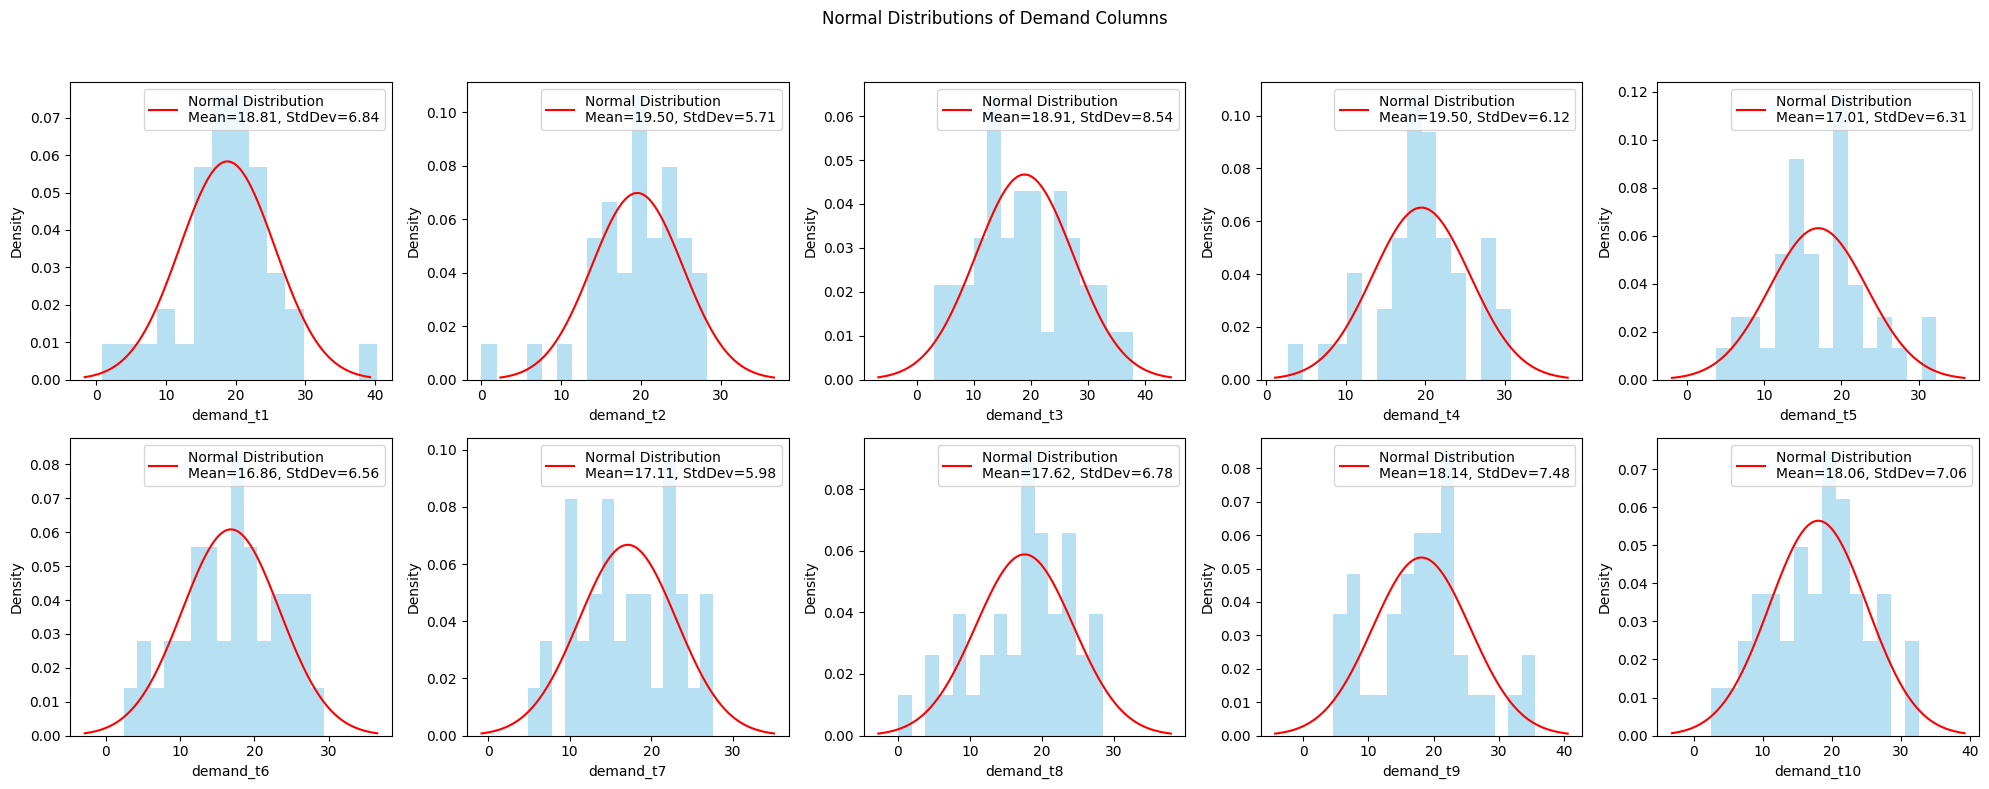

In [31]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [32]:
demand_df.cov()

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   47.953081  14.169299  40.454870  21.859039 -14.829210 -13.525379   
demand_t2   14.169299  33.467778  28.372109  12.224950 -16.354177  -7.539986   
demand_t3   40.454870  28.372109  74.753439  12.903782 -21.684936 -20.962192   
demand_t4   21.859039  12.224950  12.903782  38.427719  -9.522983  -0.024767   
demand_t5  -14.829210 -16.354177 -21.684936  -9.522983  40.895662  27.337162   
demand_t6  -13.525379  -7.539986 -20.962192  -0.024767  27.337162  44.073915   
demand_t7   -5.394437  -7.902618 -26.277987  11.576960  20.244138  31.256200   
demand_t8   -0.892880   8.545410  14.127719 -19.888718   9.613436  16.258561   
demand_t9  -15.282734  17.203391 -22.582657  16.020691  -2.772531   0.505178   
demand_t10  10.689294   7.245311   1.917413  22.235175  -3.635650  11.938956   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -5.394437  -0.892880 -15.282734   10.689294  
demand_t2   -7.902618   8.545410  17.203391    7.245311  
demand_t3  -26.277987  14.127719 -22.582657    1.917413  
demand_t4   11.576960 -19.888718  16.020691   22.235175  
demand_t5   20.244138   9.613436  -2.772531   -3.635650  
demand_t6   31.256200  16.258561   0.505178   11.938956  
demand_t7   36.649989  -1.324980  12.396981   22.173939  
demand_t8   -1.324980  47.172532  -7.357564    7.768933  
demand_t9   12.396981  -7.357564  57.456532   24.023099  
demand_t10  22.173939   7.768933  24.023099   51.191758

In [33]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    3.029558   2.139619  13.028779   3.470228   0.320130   6.149128   
demand_t2    2.139619   7.516591   4.327606   0.960134   1.129124   3.439415   
demand_t3   13.028779   4.327606  20.468485   0.580778   4.076579   9.085108   
demand_t4    3.470228   0.960134   0.580778   3.198978   6.130927   3.443365   
demand_t5    0.320130   1.129124   4.076579   6.130927   9.513903  13.192626   
demand_t6    6.149128   3.439415   9.085108   3.443365  13.192626   2.400202   
demand_t7    2.098731   1.431391   6.148555   6.238194  11.841003   8.969478   
demand_t8   12.585585   5.884536  13.560595   9.691784   2.331543   9.597056   
demand_t9    6.849077  13.421521   1.896111  12.103445   3.071458  16.294473   
demand_t10  11.601722   8.865285   8.078350  12.025217   0.305729   5.405475   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    2.098731  12.585585   6.849077   11.601722  
demand_t2    1.431391   5.884536  13.421521    8.865285  
demand_t3    6.148555  13.560595   1.896111    8.078350  
demand_t4    6.238194   9.691784  12.103445   12.025217  
demand_t5   11.841003   2.331543   3.071458    0.305729  
demand_t6    8.969478   9.597056  16.294473    5.405475  
demand_t7   11.653865   2.730073  12.727433    6.483798  
demand_t8    2.730073   5.967002   2.670730    1.583894  
demand_t9   12.727433   2.670730  10.775065    8.454821  
demand_t10   6.483798   1.583894   8.454821    8.852946

### Validate the corr matrix of damand_df is close to original setting


In [34]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.353693   0.675689   0.509214  -0.334866  -0.294205   
demand_t2    0.353693   1.000000   0.567234   0.340888  -0.442055  -0.196321   
demand_t3    0.675689   0.567234   1.000000   0.240757  -0.392197  -0.365200   
demand_t4    0.509214   0.340888   0.240757   1.000000  -0.240222  -0.000602   
demand_t5   -0.334866  -0.442055  -0.392197  -0.240222   1.000000   0.643908   
demand_t6   -0.294205  -0.196321  -0.365200  -0.000602   0.643908   1.000000   
demand_t7   -0.128677  -0.225642  -0.502041   0.308486   0.522906   0.777693   
demand_t8   -0.018773   0.215068   0.237910  -0.467132   0.218875   0.356572   
demand_t9   -0.291154   0.392311  -0.344580   0.340949  -0.057196   0.010039   
demand_t10   0.215745   0.175043   0.030996   0.501324  -0.079459   0.251348   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -0.128677  -0.018773  -0.291154    0.215745  
demand_t2   -0.225642   0.215068   0.392311    0.175043  
demand_t3   -0.502041   0.237910  -0.344580    0.030996  
demand_t4    0.308486  -0.467132   0.340949    0.501324  
demand_t5    0.522906   0.218875  -0.057196   -0.079459  
demand_t6    0.777693   0.356572   0.010039    0.251348  
demand_t7    1.000000  -0.031866   0.270153    0.511924  
demand_t8   -0.031866   1.000000  -0.141325    0.158095  
demand_t9    0.270153  -0.141325   1.000000    0.442955  
demand_t10   0.511924   0.158095   0.442955    1.000000

In [35]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [36]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [37]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (20, 10), Test size: (20, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  24.960222  20.692981  27.303691  19.653523  20.545067  13.497153   
1  21.826520  24.769591  30.066759  19.763461  15.596521  13.925413   
2  16.998202  20.773882  15.397326  20.975344  24.749545  29.382531   
3  23.045823   9.920581  25.722114  18.860021  11.619067   2.476654   
4  10.914690  27.517686  10.442886  24.735531  20.915392  24.761943   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  14.896149  20.487059  15.555696   16.855662  
1  14.491612  20.260512  20.558662   19.884258  
2  22.923089  26.180948  21.285012   21.617180  
3   4.836026   8.967788   4.624307   15.633218  
4  21.907949  18.899038  32.837033   22.420641  

Fold 2:
Train size: (20, 10), Test size: (20, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  18.252477  21.137754  26.780415  28.600846  13.811882  12.807092   
1  16.

In [38]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [39]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [40]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 182.363547616305
std of sum: 29.77151112345516
95.0 percentile of sum: 231.33332566754632
Q_star: 231.33332566754632

mean of sum: 177.17170220602944
std of sum: 32.66243711584054
95.0 percentile of sum: 230.89663036109414
Q_star: 230.89663036109414



## Data3: Qk hat df


### Functions


In [41]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [42]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [43]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [44]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [45]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [46]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [47]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [48]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

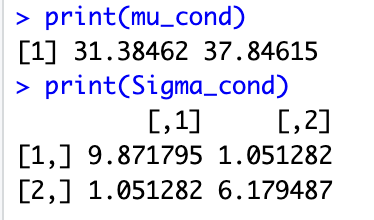
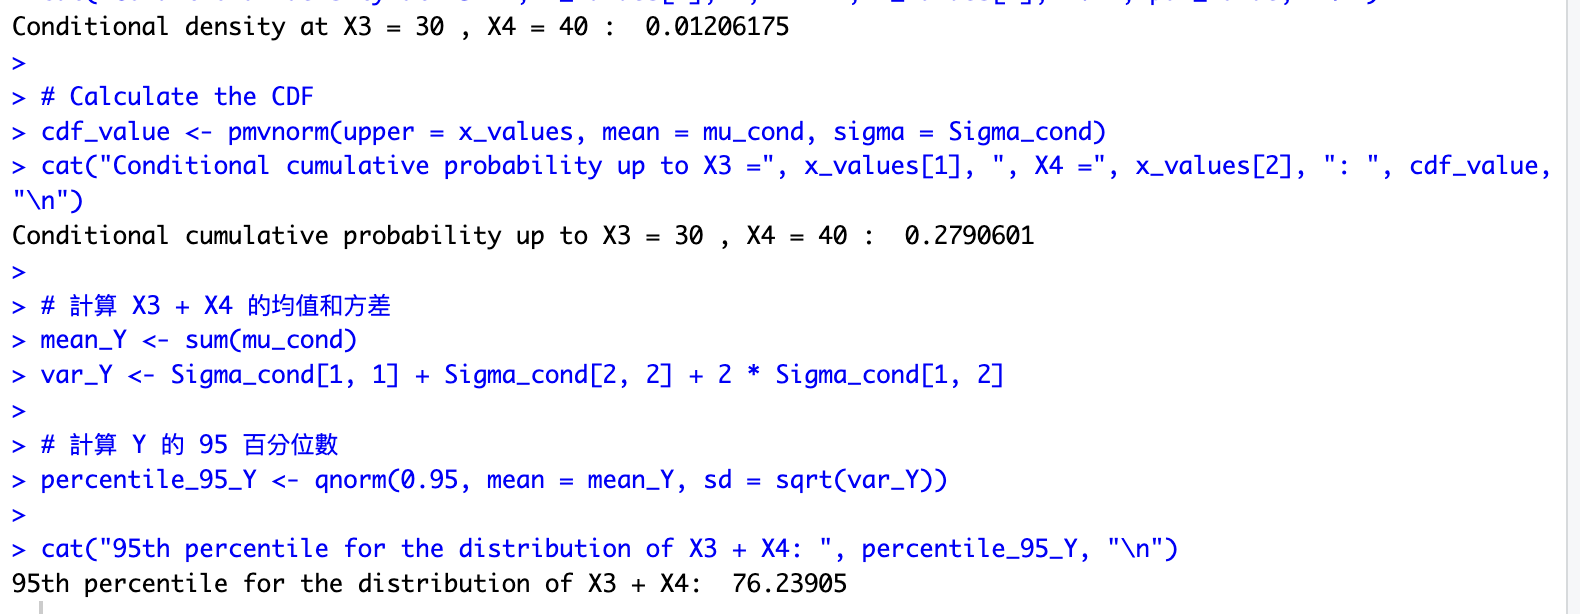


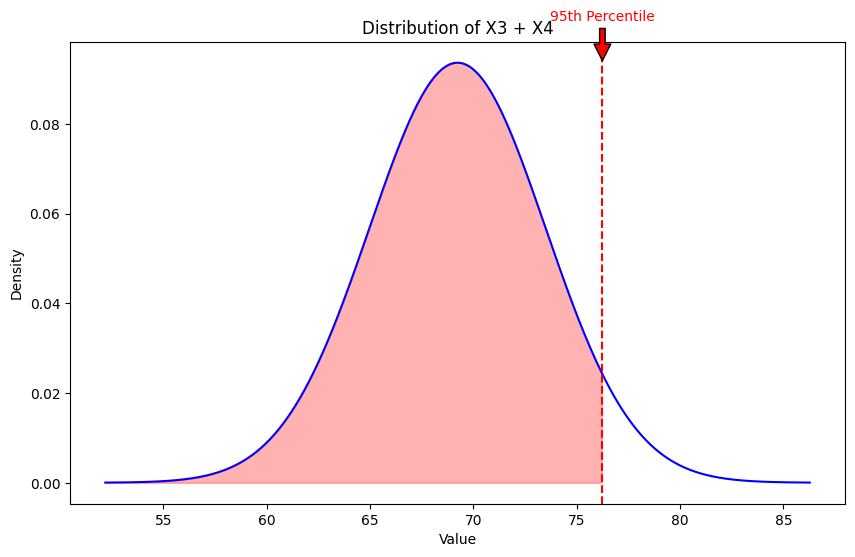

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


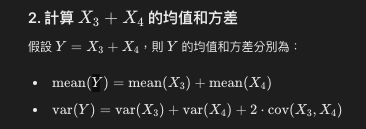


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [50]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.014324922063486
模擬計算的Y的方差: 2.9636183380746908


### Calculate Qk hat for 2~T-1 of demand_df_train


In [51]:
demand_df_train = demand_folds[0][0]

In [52]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [53]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [54]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   220.362302  175.101105  175.703565  165.472916  157.168665  160.936981   
1   229.292388  216.044617  209.195033  207.432632  205.047182  219.908301   
2   264.262719  255.409403  256.598493  251.010699  233.375017  221.579415   
3   218.748370  224.922904  223.806719  207.976630  194.463465  192.794771   
4   232.021533  218.800374  224.025571  216.500090  209.326756  174.761955   
5   231.352345  236.436302  230.380902  226.734140  222.147614  213.099840   
6   211.906487  214.721213  205.431544  206.669790  170.201706  164.693279   
7   229.743934  223.440427  227.591904  221.252605  216.867535  227.780335   
8   239.184727  239.444424  228.754482  234.517059  242.769842  241.994098   
9   232.145795  212.171506  208.331392  205.702564  201.009361  196.779455   
10  193.921280  190.416385  187.696266  194.186421  211.947761  184.404738   
11  204.171088  181.060366  175.410712  166.354897  174.976341  169.767932   
12  225.320443  220.006525  226.239944  225.666352  231.827584  223.586980   
13  236.920170  231.026183  227.197246  221.142755  226.041671  210.358566   
14  233.518749  205.226471  196.471280  197.371380  167.927654  145.247501   
15  214.939302  212.222852  209.381880  181.026008  152.396555  145.334412   
16  230.116607  238.949253  238.297972  220.909858  217.760696  224.917606   
17  222.773600  222.219925  223.999523  222.917364  233.960840  240.929748   
18  229.211019  238.117028  242.578205  231.756763  214.382433  195.298729   
19  235.454424  242.313320  237.573584  238.935732  227.853841  221.833097   
20  236.731746  226.651655  231.862847  236.110788  222.122383  229.659950   
21  218.448086  215.571272  216.665231  214.623343  210.750228  218.820946   
22  227.548340  228.392328  227.545048  229.557487  216.403121  209.091637   
23  225.002141  224.433665  217.374351  234.992668  221.596435  208.112191   
24  222.597985  210.960957  214.818582  206.693591  156.140297  152.904621   
25  222.462996  209.996406  210.593268  207.873194  207.480142  194.354455   
26  220.476430  224.416260  222.049698  226.385824  198.620866  190.212346   
27  227.920279  213.360147  224.675071  235.930940  223.786245  209.607552   
28  233.490634  224.921196  223.653080  212.580029  230.887014  218.969148   
29  232.880395  228.214213  230.077819  241.976924  227.087263  231.095952   
30  244.764216  242.469715  239.242459  229.366298  225.992401  215.363854   
31  226.051338  230.132163  223.999078  213.612686  215.445284  212.514935   
32  227.373095  238.571318  240.440324  238.830905  228.934798  218.052382   
33  211.964682  230.154744  235.880672  241.504830  246.172980  241.146577   
34  199.678425  192.388120  191.131893  181.663163  155.506562  142.723423   
35  220.391591  220.189184  218.664598  235.499846  201.721967  206.092332   
36  224.015399  206.876606  207.888064  206.232323  202.194114  203.953254   
37  222.840834  217.634267  221.605104  218.838422  212.014446  199.188893   
38  241.459821  250.581370  247.495873  235.873528  220.846443  203.361867   
39  218.332957  225.116831  227.289625  209.132432  194.867827  196.506411   

     Qk_hat_k8   Qk_hat_k9  
0   166.697652  156.594812  
1   221.010580  208.823744  
2   225.122261  221.813099  
3   179.479275  179.017465  
4   169.238579  138.553542  
5   215.843951  204.718036  
6   166.931824  162.150871  
7   224.007703  227.852478  
8   245.070973  236.241840  
9   180.328821  169.147451  
10  183.715576  185.335039  
11  167.622584  153.508003  
12  225.011864  204.261540  
13  209.517113  203.589402  
14  137.669317  131.089217  
15  143.500751  128.037576  
16  214.978410  183.316628  
17  229.824454  227.276544  
18  197.539492  204.861865  
19  230.157869  224.303832  
20  222.504010  212.775489  
21  221.248721  219.011739  
22  202.783332  176.323574  
23  193.436175  181.376889  
24  143.071862  136.826892  
25  185.694910  185.800982  
26  184.150731  155.431

### Plot the distribuction


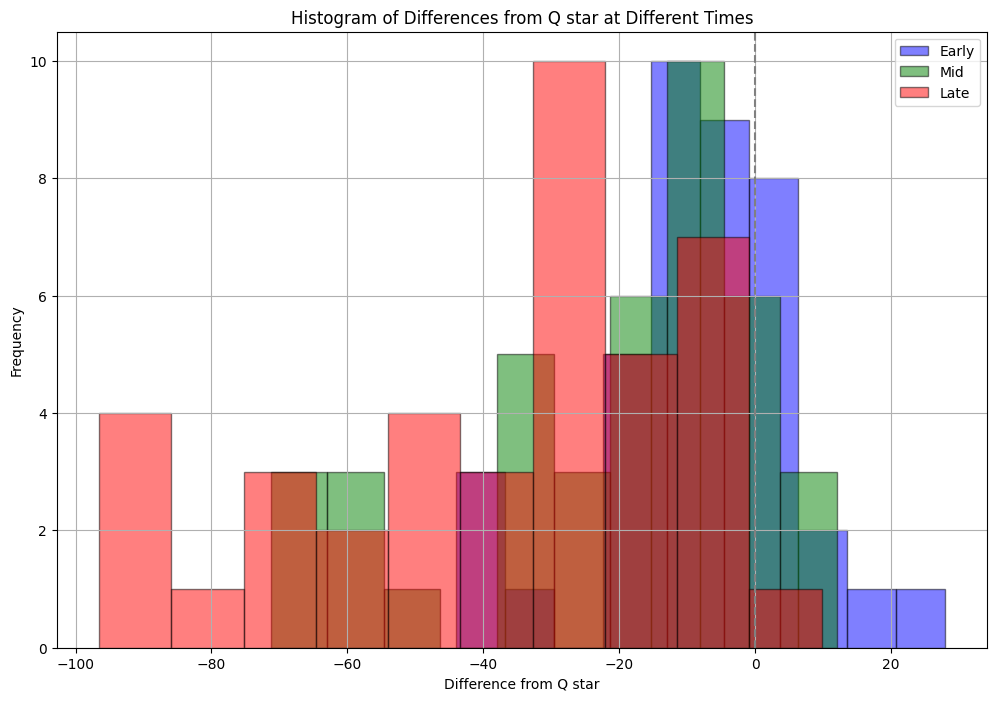

Q_star is: 230.89663036109414
Early bias: -8.175792219038962
Mid bias: -21.658466426803038
Late bias: -36.48651424909383


In [55]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

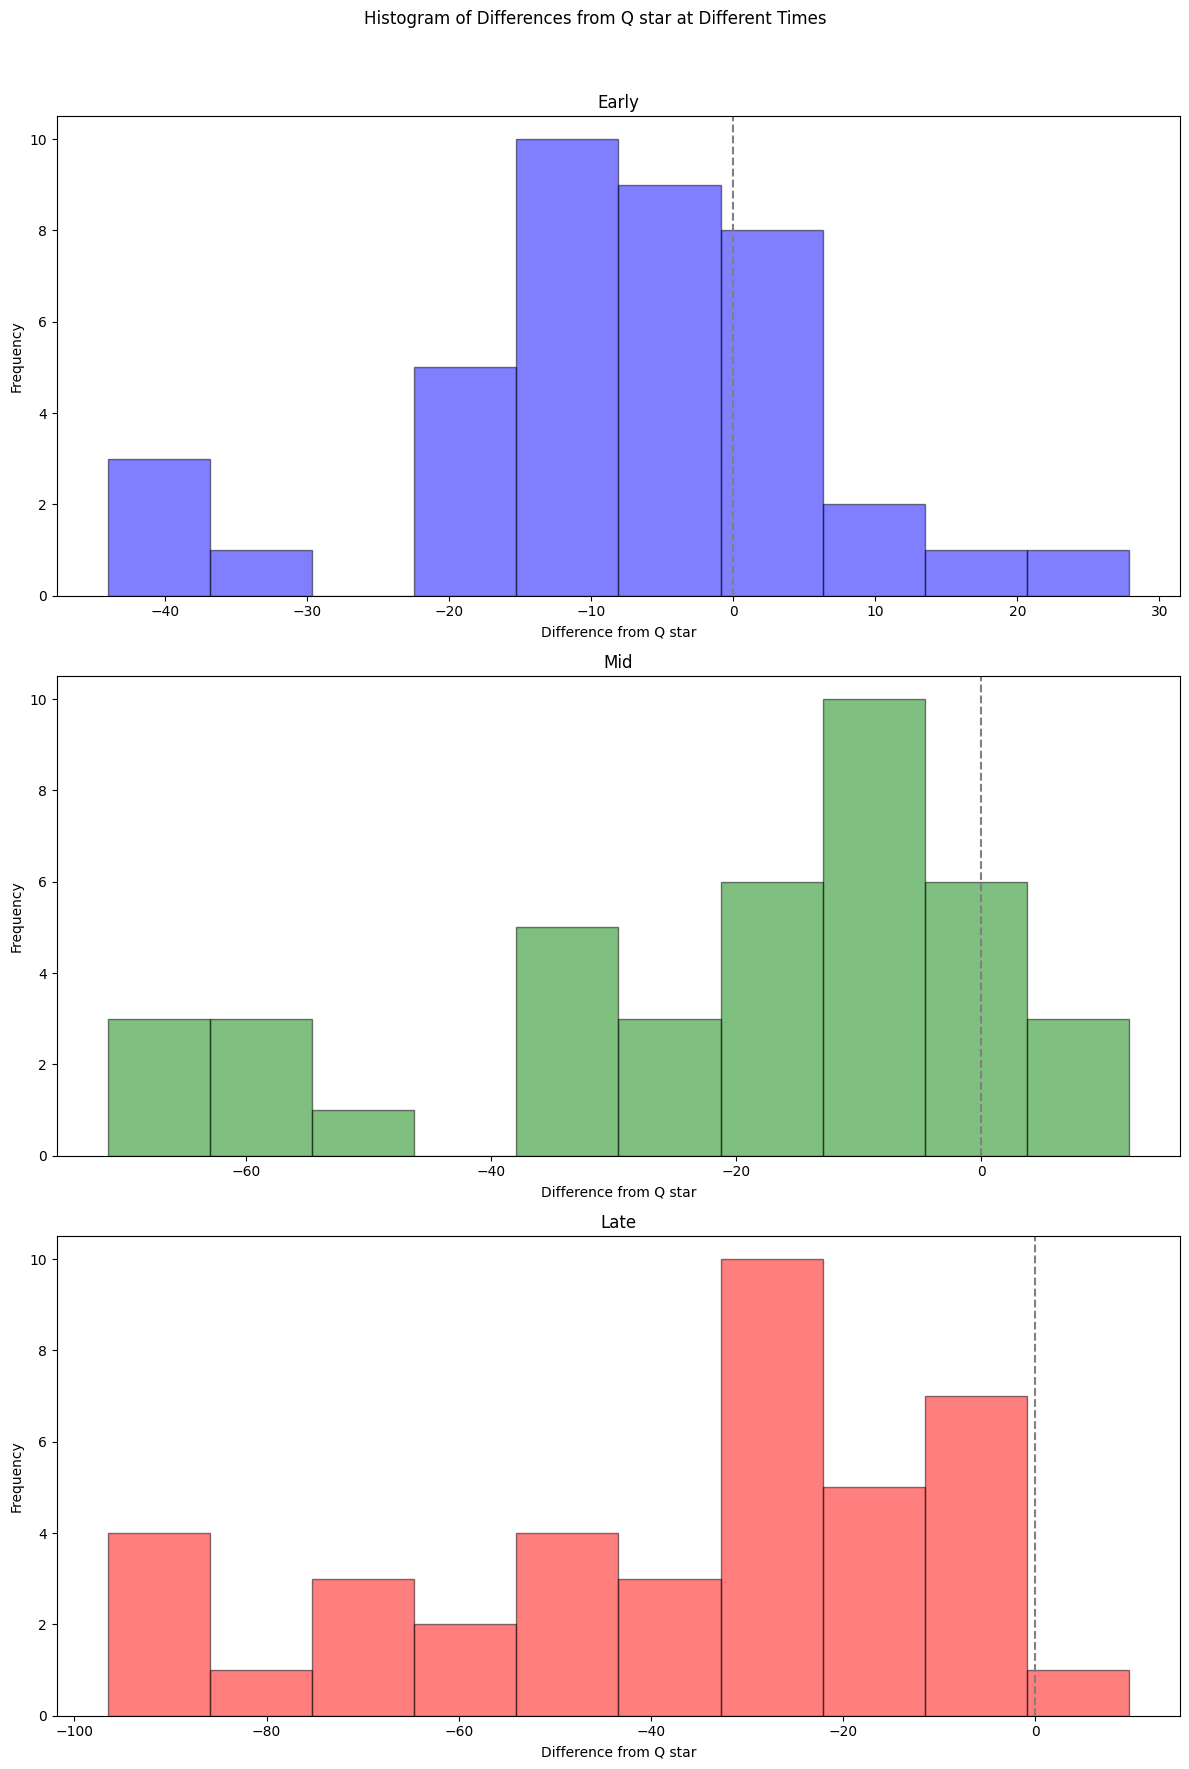

In [56]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## S0 - One-time Procurement


In [57]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value, holding_cost):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_holding_costs = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量
        holding_costs = 0  # 追蹤總持有成本

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales
            holding_costs += holding_cost * inventory

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print(f"Holding Cost: {holding_costs}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = (
            operation_profit
            - left_penalty_cost
            - ((price - cost) * total_lost)
            - holding_costs
        )

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [58]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [59]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [60]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [61]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [62]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 引入二進制變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")

            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i] - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(
                Sold_0s[i] >= Q0_vars[i] - M * Sold_0_binary, name=f"Sold_0_lb2_{i}"
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Qk_hat.append(Q_hats[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [63]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)  # 紀錄該策略組合每一次模擬的 Q0
            results_dict["Q1_vars"].append(Q1_vars)  # 紀錄該策略組合每一次模擬的 Q1

            print(f"The average profits is {average_profits}")

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [64]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [65]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                all_Fs,
                all_Q0s,
                all_Q1s,
                beta_values,
                tau_values,
                all_holding_costs_0,
                all_holding_costs_1,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(all_losses) / len(all_losses) if all_losses else 0
            average_lefts = sum(all_lefts) / len(all_lefts) if all_lefts else 0
            average_profits = sum(all_profits) / len(all_profits) if all_profits else 0
            average_operation_profits = (
                sum(all_operation_profits) / len(all_operation_profits)
                if all_operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(all_Fs)
            results_dict["Q0_vars"].append(all_Q0s)
            results_dict["Q1_vars"].append(all_Q1s)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": all_Fs,
                    "profits": all_profits,
                    "losses": all_losses,
                    "lefts": all_lefts,
                    "operation_profits": all_operation_profits,
                    "Q0": all_Q0s,
                    "Q1": all_Q1s,
                    "hc0": all_holding_costs_0,
                    "hc1": all_holding_costs_1,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [66]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [67]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [68]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [69]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [70]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [71]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S4 - Beta with softmax


In [72]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [73]:
def fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [74]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [75]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [76]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [77]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [78]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [79]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [80]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [81]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [82]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411271920

In [83]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [84]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [85]:
training_df.shape

(20, 2)

In [86]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 182.363547616305
std of sum: 29.77151112345516
50.0 percentile of sum: 182.363547616305
Q_star: 182.363547616305


In [87]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   186.860420  186.921347  186.975603  186.810766  203.829510  192.168524   
1   184.557997  195.469757  189.165111  188.929485  197.695957  196.114144   
2   181.010488  183.637531  189.211226  189.409634  215.012140  221.288996   
3   185.453854  159.875379  150.659677  151.130876  133.197216  119.632259   
4   176.540752  197.385654  205.954738  206.591836  220.760078  211.912548   
5   183.892882  181.798041  194.241390  194.207344  192.175068  208.918760   
6   182.912485  199.659463  206.413893  206.568991  197.859149  193.270361   
7   183.706157  173.805189  166.114482  166.153318  183.551018  206.631159   
8   180.060556  187.124772  184.129369  184.627242  162.617673  162.871578   
9   182.063666  180.017011  194.818689  195.357113  206.671928  196.144446   
10  182.365908  190.908450  182.778886  181.717947  204.823281  202.422372   
11  180.937867  171.235241  181.032214  180.674267  122.056979  127.697662   
12  176.516687  180.301277  161.810498  161.502581  144.646030  144.594738   
13  181.932041  185.071139  175.083361  176.921635  176.364450  174.792603   
14  179.221789  178.247455  181.246804  181.232901  191.063376  199.095177   
15  186.254301  200.106666  197.486953  197.911583  191.512086  200.326689   
16  184.886107  168.204145  167.259821  167.460099  176.628084  177.036603   
17  188.737670  206.522710  208.810418  208.073371  191.691742  186.908649   
18  179.345963  188.477994  187.133911  185.518094  186.224841  181.890722   
19  180.013361  132.501730  136.943908  136.471871  148.890347  143.552963   

     Qk_hat_k8   Qk_hat_k9  
0   193.280944  195.186814  
1   199.282829  196.833488  
2   216.285947  218.748282  
3   118.183616  122.744460  
4   209.432257  214.844595  
5   207.644422  214.184243  
6   199.779147  192.273115  
7   207.440178  201.302576  
8   162.638502  148.594324  
9   200.013368  194.801368  
10  201.632300  197.896916  
11  124.882581  124.462754  
12  149.075579  154.985058  
13  169.763996  172.366779  
14  202.488166  208.649680  
15  206.809481  211.013605  
16  168.838437  163.113600  
17  185.207678  190.994101  
18  175.602623  174.239456  
19  148.988900  150.035738

## Training


### S0 - One-time procurement strategy


In [88]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/20 with initial inventory Q_star=182.363547616305
--------------------------------------------------
Day 1
Demand      : 24.960221500000742
Sales       : 24.960221500000742
Loss        : 0
Left        : 157.40332611630424
Inventory   : 157.40332611630424
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 20.692981255066673
Sales       : 20.692981255066673
Loss        : 0
Left        : 136.71034486123756
Inventory   : 136.71034486123756
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 27.303690868175586
Sales       : 27.303690868175586
Loss        : 0
Left        : 109.40665399306198
Inventory   : 109.40665399306198
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 19.653522587646712
Sales       : 19.6535

In [89]:
baseline_stimulation_df

losses      lefts  operation_profits       profits
0   12.083654   0.000000       91181.773808  85139.946559
1   18.779761   0.000000       91181.773808  81791.893204
2   37.919512   0.000000       91181.773808  72222.017875
3    0.000000  56.657948       62852.799779  34523.825750
4   32.989242   0.000000       91181.773808  74687.152859
5   39.284807   0.000000       91181.773808  71539.370288
6   14.798713   0.000000       91181.773808  83782.417402
7   19.334024   0.000000       91181.773808  81514.761647
8    0.000000  35.921260       73221.144010  55260.514211
9   11.118860   0.000000       91181.773808  85622.344030
10  12.226429   0.000000       91181.773808  85068.559118
11   0.000000  60.251224       61056.161807  30930.549806
12   0.000000  25.158607       78602.470273  66023.166738
13   0.000000  10.202728       86080.410008  80979.046208
14  17.115371   0.000000       91181.773808  82624.088143
15  26.644755   0.000000       91181.773808  77859.396125
16   0.000000  21.390720       80486.413774  69791.053740
17   4.466659   0.000000       91181.773808  88948.444237
18   0.000000   5.040487       88661.530370  86141.286932
19   0.000000  32.138815       75112.366233  59042.958657

### S1 - Grid for Fixed F & Fixed Rk


In [90]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 182.363547616305
期初庫存 Q0: 18.2363547616305
重新估計量 Qk_hat: 186.86042006458922
訂貨量 Q1 為 168.6240653029587

第一階段：期初庫存 Q0: 18.2363547616305，需求量為 24.960221500000742，Sold_0 為 18.2363547616305，Left_0 為 0.0，Lost_0 為 6.723866738370241
第二階段：期初庫存 Q1+left_0 為 168.6240653029587，需求量為 169.48698061486343，Sold_1 為 168.6240653029587，Left_1 為 0.0，Lost_1 為 0.8629153119047146

統計結果：Sold 為 186.86042006458922, Lost 為 7.586782050274955 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 3793.3910251374778，Profit 為 89636.81900715713
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 182.363547616305
期初庫存 Q0: 18.2363547616305
重新估計量 Qk_hat: 184.55799658741168
訂貨量 Q1 為 166.32164182578117

第一階段：期初庫存 Q0: 18.2363547616305，需求量為 21.826519782093175，Sold_0 為 18.2363547616305，Left_0 為 0.0，Lost_0 為 3.590165020462674
第二階段：期初庫存 Q1+left_0 為 166.32164182578117，需求量為 179.31678904234306，Sold_1 為 166.32164182578117，Left_1 為 0.0，Lost_1 為 12.99514721656189

統計結果：Sold 為 184.5579

R(T)    F                                                 Q0  \
51     7  0.7  [127.65448333141352, 127.65448333141352, 127.6...   
61     8  0.8  [145.890838093044, 145.890838093044, 145.89083...   
52     7  0.8  [145.890838093044, 145.890838093044, 145.89083...   
62     8  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
53     7  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
..   ...  ...                                                ...   
65     9  0.3  [54.70906428489151, 54.70906428489151, 54.7090...   
45     7  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
54     8  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
64     9  0.2  [36.472709523261, 36.472709523261, 36.47270952...   
63     9  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   

                                                   Q1  average_profits  \
51  [64.51404043268859, 68.45966069061639, 93.6345...     86755.774250   
61  [47.39010572765039, 53.39199098539328, 70.3951...     86237.185406   
52  [46.277685671058094, 50.223305928985894, 75.39...     86073.410749   
62  [29.153750966019913, 35.1556362237628, 52.1587...     85643.584594   
53  [28.041330909427614, 31.986951167355414, 57.16...     85391.984653   
..                                                ...              ...   
65  [140.47774993342927, 142.1244237253428, 164.03...    -47572.365302   
45  [173.9321690024716, 177.8777892603994, 203.052...    -49735.225196   
54  [175.0445890590639, 181.04647431680678, 198.04...    -74269.786646   
64  [158.71410469505975, 160.3607784869733, 182.27...    -74926.897445   
63  [176.95045945669025, 178.5971332486038, 200.51...   -102281.429587   

    average_losses  average_lefts  average_operation_profits  
51        2.816963       3.218074               89773.292488  
61        2.484468       4.920242               89939.539994  
52        2.604147       5.008433               89879.700539  
62        1.744346       7.587686               90309.600614  
53        1.821747       7.936085               90270.900460  
..             ...            ...                        ...  
65       92.502759      92.502759               44930.394105  
45       93.944666      93.944666               44209.440807  
54      110.301040     110.301040               36031.253657  
64      110.739114     110.739114               35812.216724  
63      128.975469     128.975469               26694.039343  

[72 rows x 8 columns]

In [91]:
stimulation_results_df_1

R(T)    F        profits     losses      lefts     Left0s     Left1s  \
0      7  0.7   94944.922707   2.278678   0.000000   1.001847   0.000000   
1      7  0.7   95542.489610   5.029165   0.000000   1.706218   0.000000   
2      7  0.7  108705.041094   0.622347   1.628283   0.000000   1.628283   
3      7  0.7   61878.357892   0.000000   1.948884  36.010223   1.948884   
4      7  0.7  104236.153513   3.440241   0.000000   8.366355   0.000000   
5      7  0.7   98094.583002  12.729594   0.000000   7.157894   0.000000   
6      7  0.7   94689.230467   3.891900   0.000000   9.487340   0.000000   
7      7  0.7   98381.992499   0.000000   4.933587   0.530651   4.933587   
8      7  0.7   65006.499228   0.000000  16.429290  26.054689  16.429290   
9      7  0.7   95410.183942   0.000000   2.662039  10.965425   2.662039   
10     7  0.7   93378.791193   0.000000   7.832395   5.428435   7.832395   
11     7  0.7   58263.492765   0.000000   5.585338  55.160294   5.585338   
12     7  0.7   65992.267478  12.610203   0.000000  39.253544   0.000000   
13     7  0.7   84764.518670   0.000000   2.631783   6.264018   2.631783   
14     7  0.7   99355.717770   0.383742   0.000000  14.884603   0.000000   
15     7  0.7   95822.537724   8.681614   0.000000   0.000000   0.000000   
16     7  0.7   72454.525921   0.000000  16.063776  13.138325  16.063776   
17     7  0.7   93375.882299   0.000000   0.078442   4.815070   0.078442   
18     7  0.7   86377.699980   0.000000   4.567661  27.432916   4.567661   
19     7  0.7   68440.597242   6.671769   0.000000  45.984693   0.000000   

    operation_profits          Q0         Q1  
0        96084.261882  127.654483  64.514040  
1        98057.072011  127.654483  68.459661  
2       109830.356209  127.654483  93.634512  
3        62852.799779  127.654483   0.000000  
4       105956.274135  127.654483  84.258065  
5       104459.380166  127.654483  81.264277  
6        96635.180341  127.654483  65.615877  
7       100848.785969  127.654483  78.976676  
8        73221.144010  127.654483  35.217094  
9        96741.203587  127.654483  68.489963  
10       97294.988499  127.654483  74.767888  
11       61056.161807  127.654483   0.043178  
12       72297.368876  127.654483  16.940254  
13       86080.410008  127.654483  47.138119  
14       99547.588621  127.654483  71.440694  
15      100163.344608  127.654483  72.672206  
16       80486.413774  127.654483  49.382120  
17       93415.103379  127.654483  59.254166  
18       88661.530370  127.654483  54.236238  
19       71776.481737  127.654483  15.898480

In [92]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 182.363547616305
Maximum Profit: 86755.77424978417


In [93]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
51     7  0.7     86755.774250
61     8  0.8     86237.185406
52     7  0.8     86073.410749

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_linear_constraint_med_with_holding_cost_0_40_202411271920.png


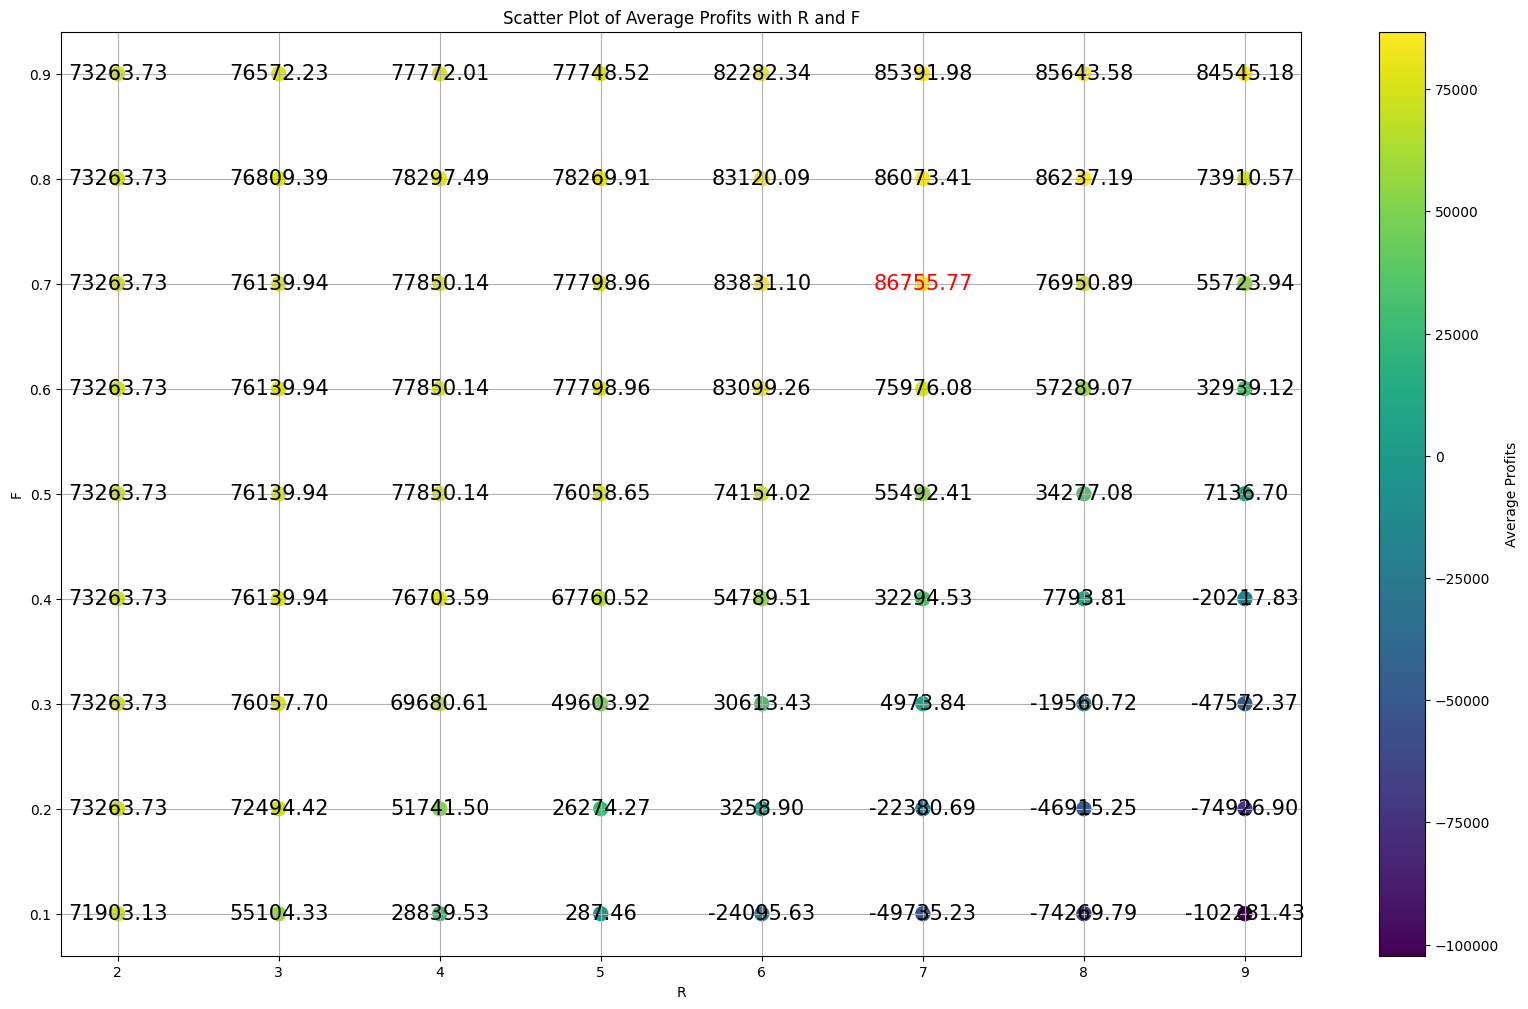

In [94]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_linear_constraint_med_with_holding_cost_0_40_202411271920.png


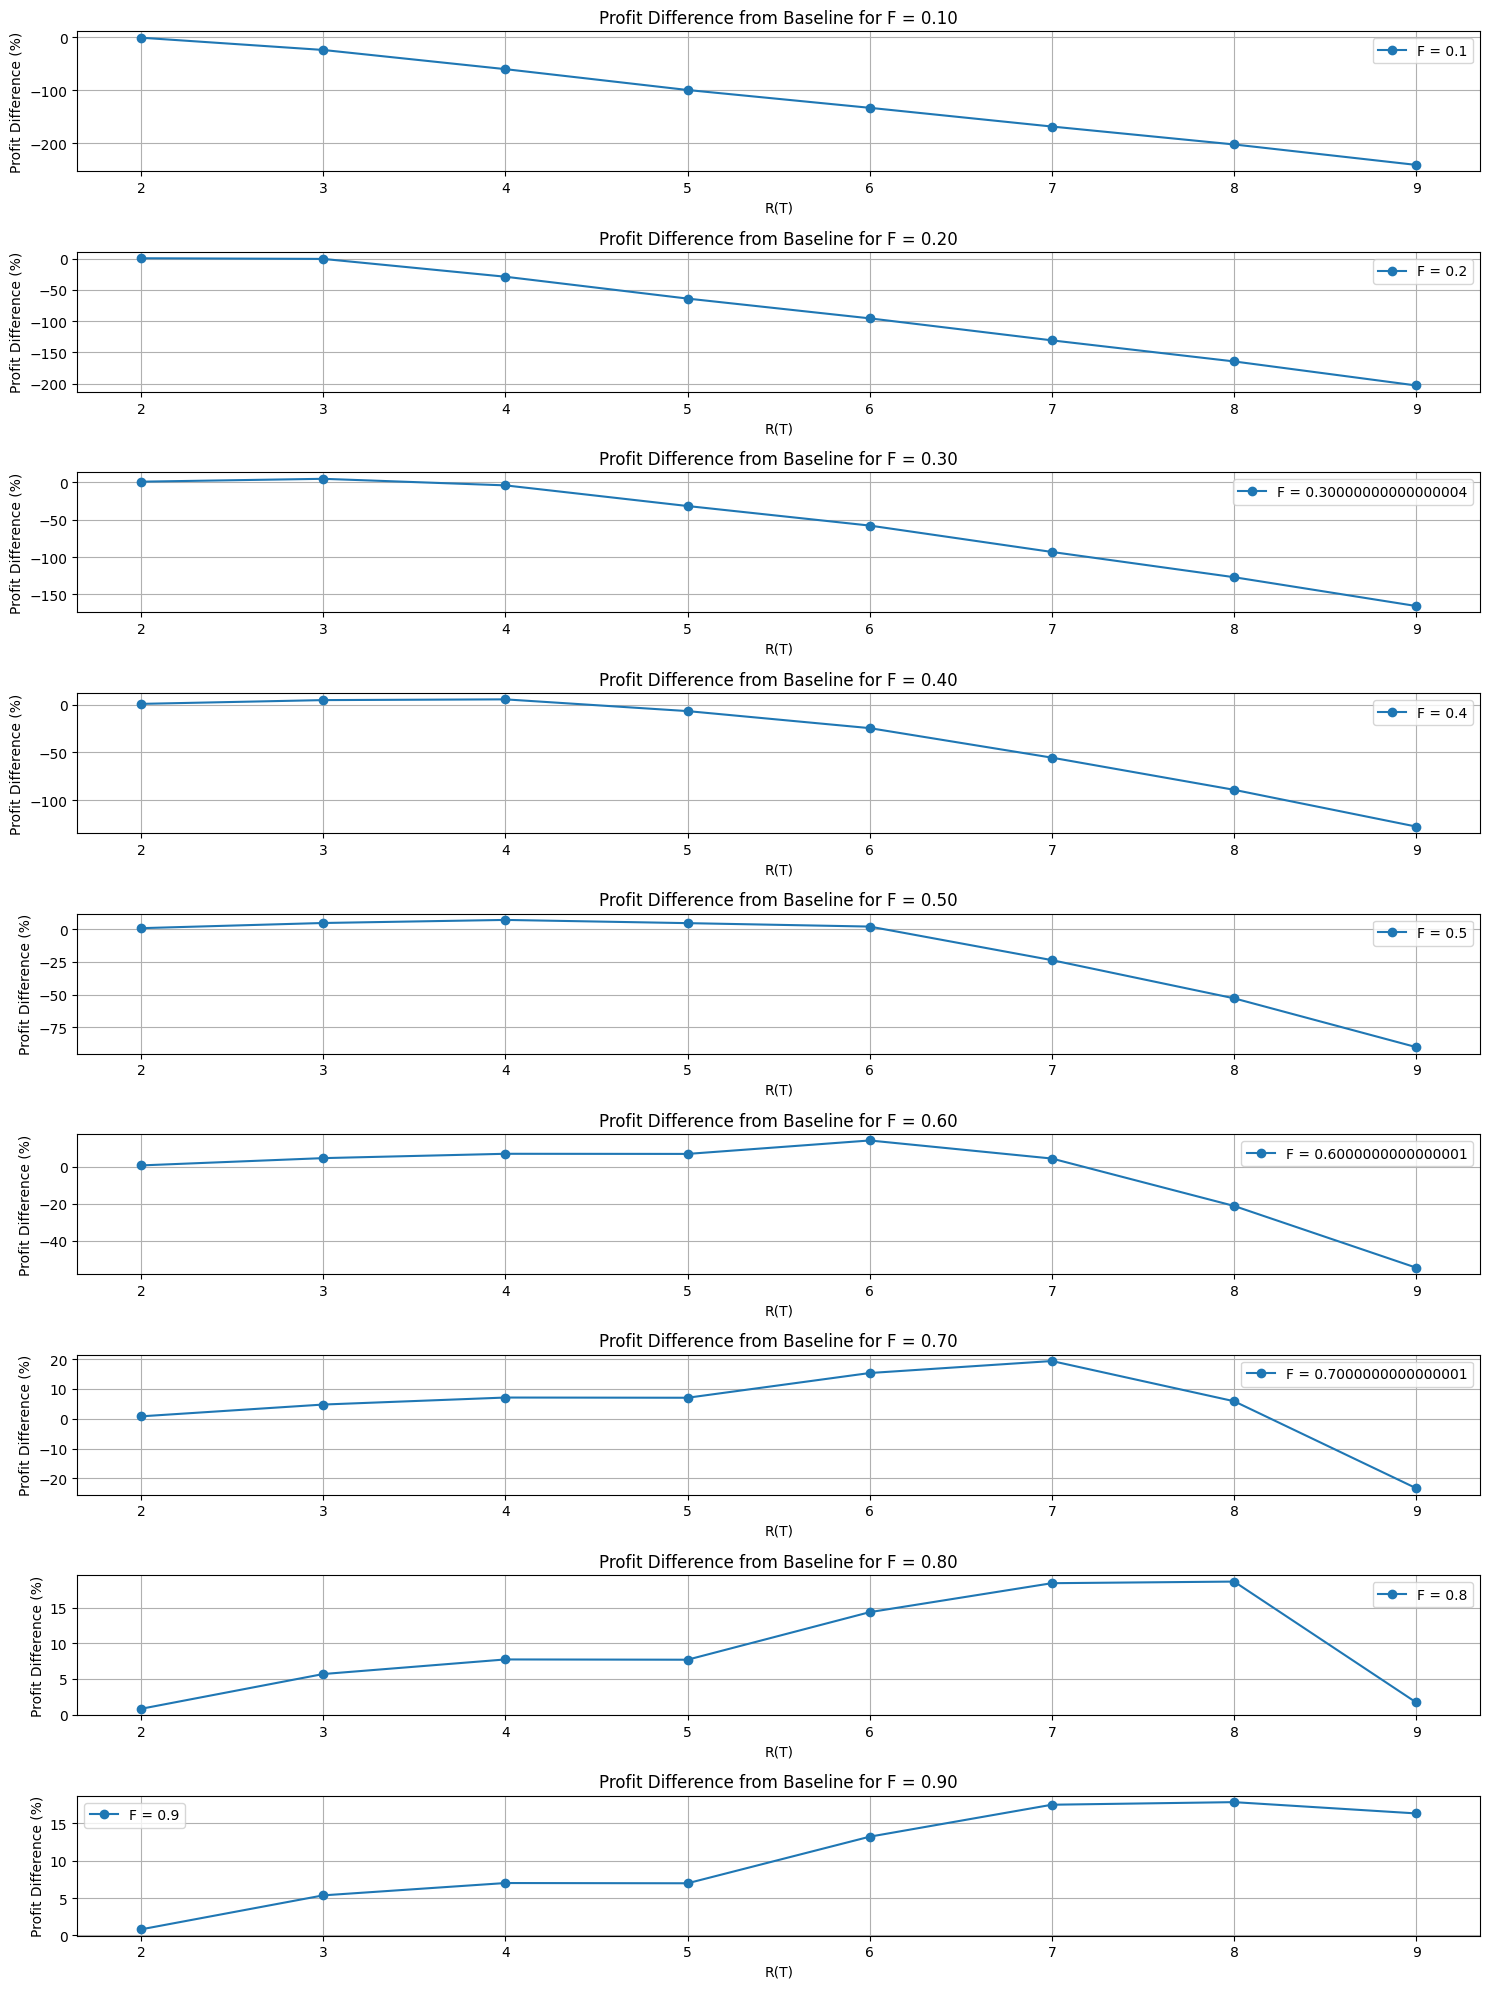

In [95]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [96]:
results_df_8, stimulation_results_df_8 = None, None

results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
    holding_cost=holding_cost,
)
results_df_8





max_profit is changed from None to 71903.13456419806




max_profit is changed from 71903.13456419806 to 73263.72574102474








































max_profit is changed from 73263.72574102474 to 76057.69514101472




max_profit is changed from 76057.69514101472 to 76139.93923225529
















max_profit is changed from 76139.93923225529 to 76809.39463946581
























max_profit is changed from 76809.39463946581 to 77850.13997594107












max_profit is changed from 77850.13997594107 to 78297.48646311343
































































max_profit is changed from 78297.48646311343 to 83099.26199135046




max_profit is changed from 83099.26199135046 to 83831.09859544117




































max_profit is changed from 83831.09859544117 to 86755.77424978417


















































































R(T)    F                                                 Q0  \
51     7  0.7  [127.65448333141352, 127.65448333141352, 127.6...   
61     8  0.8  [145.890838093044, 145.890838093044, 145.89083...   
52     7  0.8  [145.890838093044, 145.890838093044, 145.89083...   
62     8  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
53     7  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
..   ...  ...                                                ...   
65     9  0.3  [54.70906428489151, 54.70906428489151, 54.7090...   
45     7  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
54     8  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
64     9  0.2  [36.472709523261, 36.472709523261, 36.47270952...   
63     9  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   

                                                   Q1  average_profits  \
51  [64.51404043268859, 68.45966069061639, 93.6345...     86755.774250   
61  [47.39010572765039, 53.39199098539328, 70.3951...     86237.185406   
52  [46.277685671058094, 50.223305928985894, 75.39...     86073.410749   
62  [29.153750966019913, 35.1556362237628, 52.1587...     85643.584594   
53  [28.041330909427614, 31.986951167355414, 57.16...     85391.984653   
..                                                ...              ...   
65  [140.47774993342927, 142.1244237253428, 164.03...    -47572.365302   
45  [173.9321690024716, 177.8777892603994, 203.052...    -49735.225196   
54  [175.0445890590639, 181.04647431680678, 198.04...    -74269.786646   
64  [158.71410469505975, 160.3607784869733, 182.27...    -74926.897445   
63  [176.95045945669025, 178.5971332486038, 200.51...   -102281.429587   

    average_losses  average_lefts  average_operation_profits  
51        2.816963       3.218074               89773.292488  
61        2.484468       4.920242               89939.539994  
52        2.604147       5.008433               89879.700539  
62        1.744346       7.587686               90309.600614  
53        1.821747       7.936085               90270.900460  
..             ...            ...                        ...  
65       92.502759      92.502759               44930.394105  
45       93.944666      93.944666               44209.440807  
54      110.301040     110.301040               36031.253657  
64      110.739114     110.739114               35812.216724  
63      128.975469     128.975469               26694.039343  

[72 rows x 8 columns]

In [97]:
stimulation_results_df_8

R(T)    F        profits     losses      lefts  operation_profits  \
0      7  0.7   94944.922707   2.278678   0.000000       96084.261882   
1      7  0.7   95542.489610   5.029165   0.000000       98057.072011   
2      7  0.7  108705.041094   0.622347   1.628283      109830.356209   
3      7  0.7   61878.357892   0.000000   1.948884       62852.799779   
4      7  0.7  104236.153513   3.440241   0.000000      105956.274135   
5      7  0.7   98094.583002  12.729594   0.000000      104459.380166   
6      7  0.7   94689.230467   3.891900   0.000000       96635.180341   
7      7  0.7   98381.992499   0.000000   4.933587      100848.785969   
8      7  0.7   65006.499228   0.000000  16.429290       73221.144010   
9      7  0.7   95410.183942   0.000000   2.662039       96741.203587   
10     7  0.7   93378.791193   0.000000   7.832395       97294.988499   
11     7  0.7   58263.492765   0.000000   5.585338       61056.161807   
12     7  0.7   65992.267478  12.610203   0.000000       72297.368876   
13     7  0.7   84764.518670   0.000000   2.631783       86080.410008   
14     7  0.7   99355.717770   0.383742   0.000000       99547.588621   
15     7  0.7   95822.537724   8.681614   0.000000      100163.344608   
16     7  0.7   72454.525921   0.000000  16.063776       80486.413774   
17     7  0.7   93375.882299   0.000000   0.078442       93415.103379   
18     7  0.7   86377.699980   0.000000   4.567661       88661.530370   
19     7  0.7   68440.597242   6.671769   0.000000       71776.481737   

            Q0         Q1         hc0         hc1     Left0s     Left1s  \
0   127.654483  64.514040  579.511113   98.273832   1.001847   0.000000   
1   127.654483  68.459661  593.461087  105.248819   1.706218   0.000000   
2   127.654483  93.634512  663.866987  142.894193   0.000000   1.628283   
3   127.654483   0.000000  490.994118   56.938660  36.010223   1.948884   
4   127.654483  84.258065  660.836709  138.936629   8.366355   0.000000   
5   127.654483  81.264277  648.229962  132.633256   7.157894   0.000000   
6   127.654483  65.615877  608.273101  112.654826   9.487340   0.000000   
7   127.654483  78.976676  621.485431  126.661371   0.530651   4.933587   
8   127.654483  35.217094  566.778801  116.551610  26.054689  16.429290   
9   127.654483  68.489963  621.329615  123.176142  10.965425   2.662039   
10  127.654483  74.767888  623.552419  132.043077   5.428435   7.832395   
11  127.654483   0.043178  548.573868   91.183216  55.160294   5.585338   
12  127.654483  16.940254  551.544845   84.290698  39.253544   0.000000   
13  127.654483  47.138119  543.169862   84.050880   6.264018   2.631783   
14  127.654483  71.440694  641.939340  129.487945  14.884603   0.000000   
15  127.654483  72.672206  600.980068  109.008309   0.000000   0.000000   
16  127.654483  49.382120  570.524786  117.876332  13.138325  16.063776   
17  127.654483  59.254166  575.171156   96.221516   4.815070   0.078442   
18  127.654483  54.236238  627.970913  129.355222  27.432916   4.567661   
19  127.654483  15.898480  568.612968   92.824759  45.984693   0.000000   

      lost0s     lost1s  
0   0.000000   2.278678  
1   0.000000   5.029165  
2   0.622347   0.000000  
3   0.000000   0.000000  
4   0.000000   3.440241  
5   0.000000  12.729594  
6   0.000000   3.891900  
7   0.000000   0.000000  
8   0.000000   0.000000  
9   0.000000   0.000000  
10  0.000000   0.000000  
11  0.000000   0.000000  
12  0.000000  12.610203  
13  0.000000   0.000000  
14  0.000000   0.383742  
15  3.550942   5.130672  
16  0.000000   0.000000  
17  0.000000   0.000000  
18  0.000000   0.000000  
19  0.000000   6.671769

In [98]:
# 比較結果
max_profit = results_df_8["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 182.363547616305
Maximum Profit: 86755.77424978417


In [99]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_8.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
51     7  0.7     86755.774250
61     8  0.8     86237.185406
52     7  0.8     86073.410749

Plot saved as plots/grid_fixed_F_fixed_R_metrics_s8_train_linear_constraint_med_with_holding_cost_0_40_202411271920.png


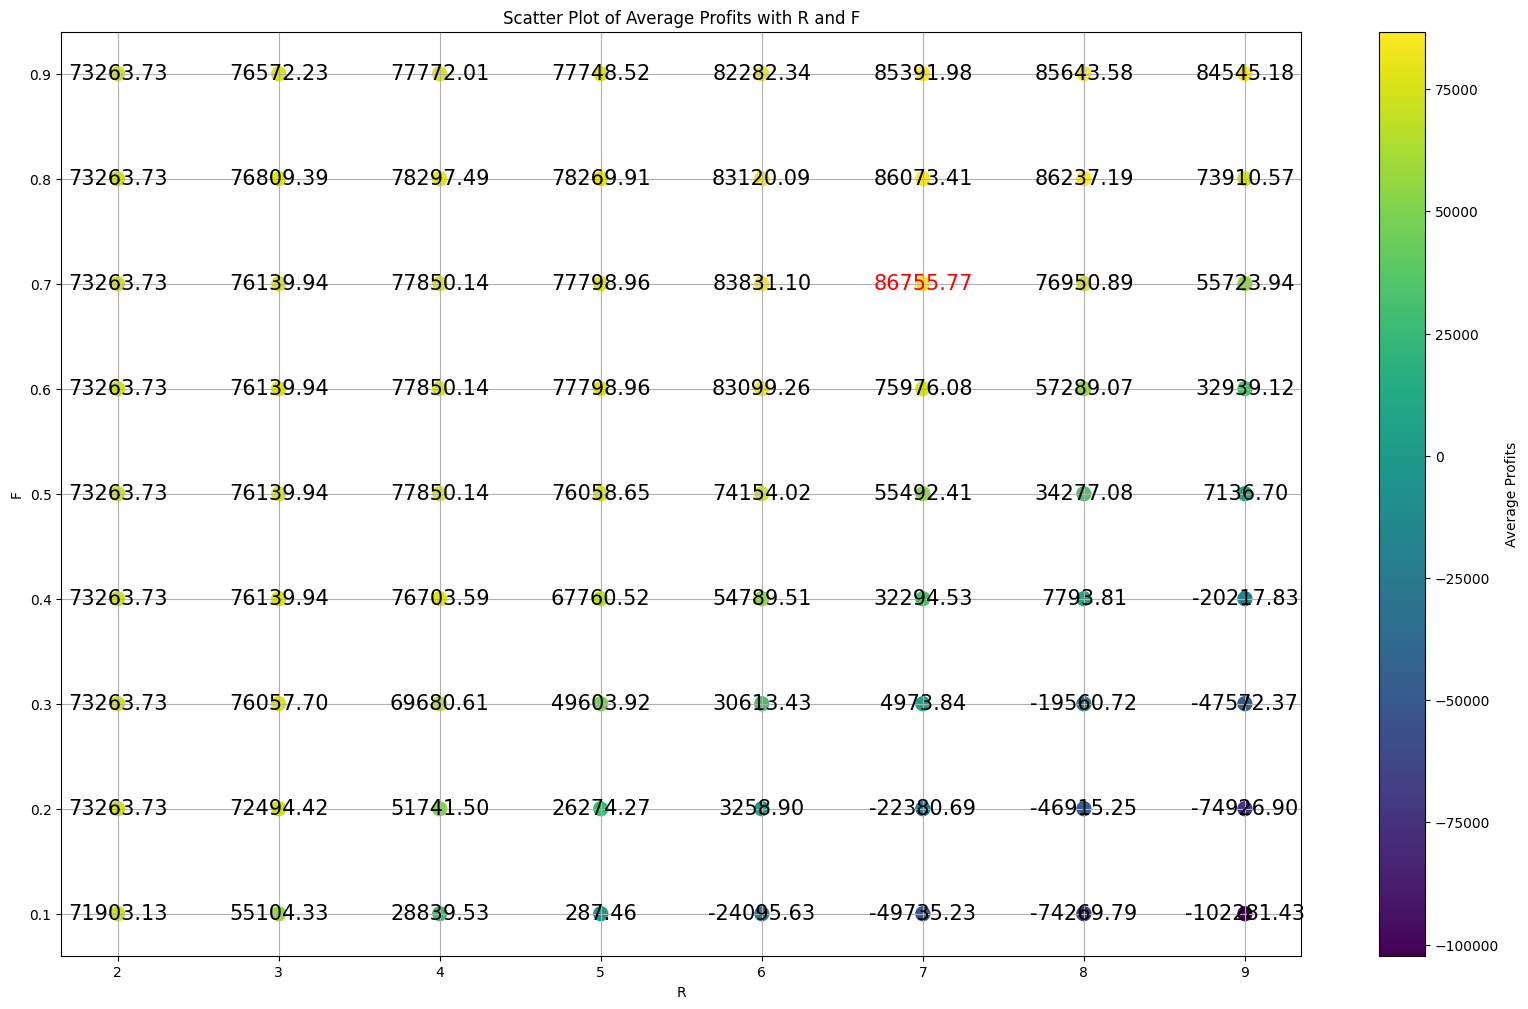

In [100]:
# 找到 'average_profits' 的最大值
max_profit = results_df_8["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_8["R(T)"],
    results_df_8["F"],
    c=results_df_8["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_8)):
    avg_profit = results_df_8["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_s8_train_linear_constraint_med_with_holding_cost_0_40_202411271920.png


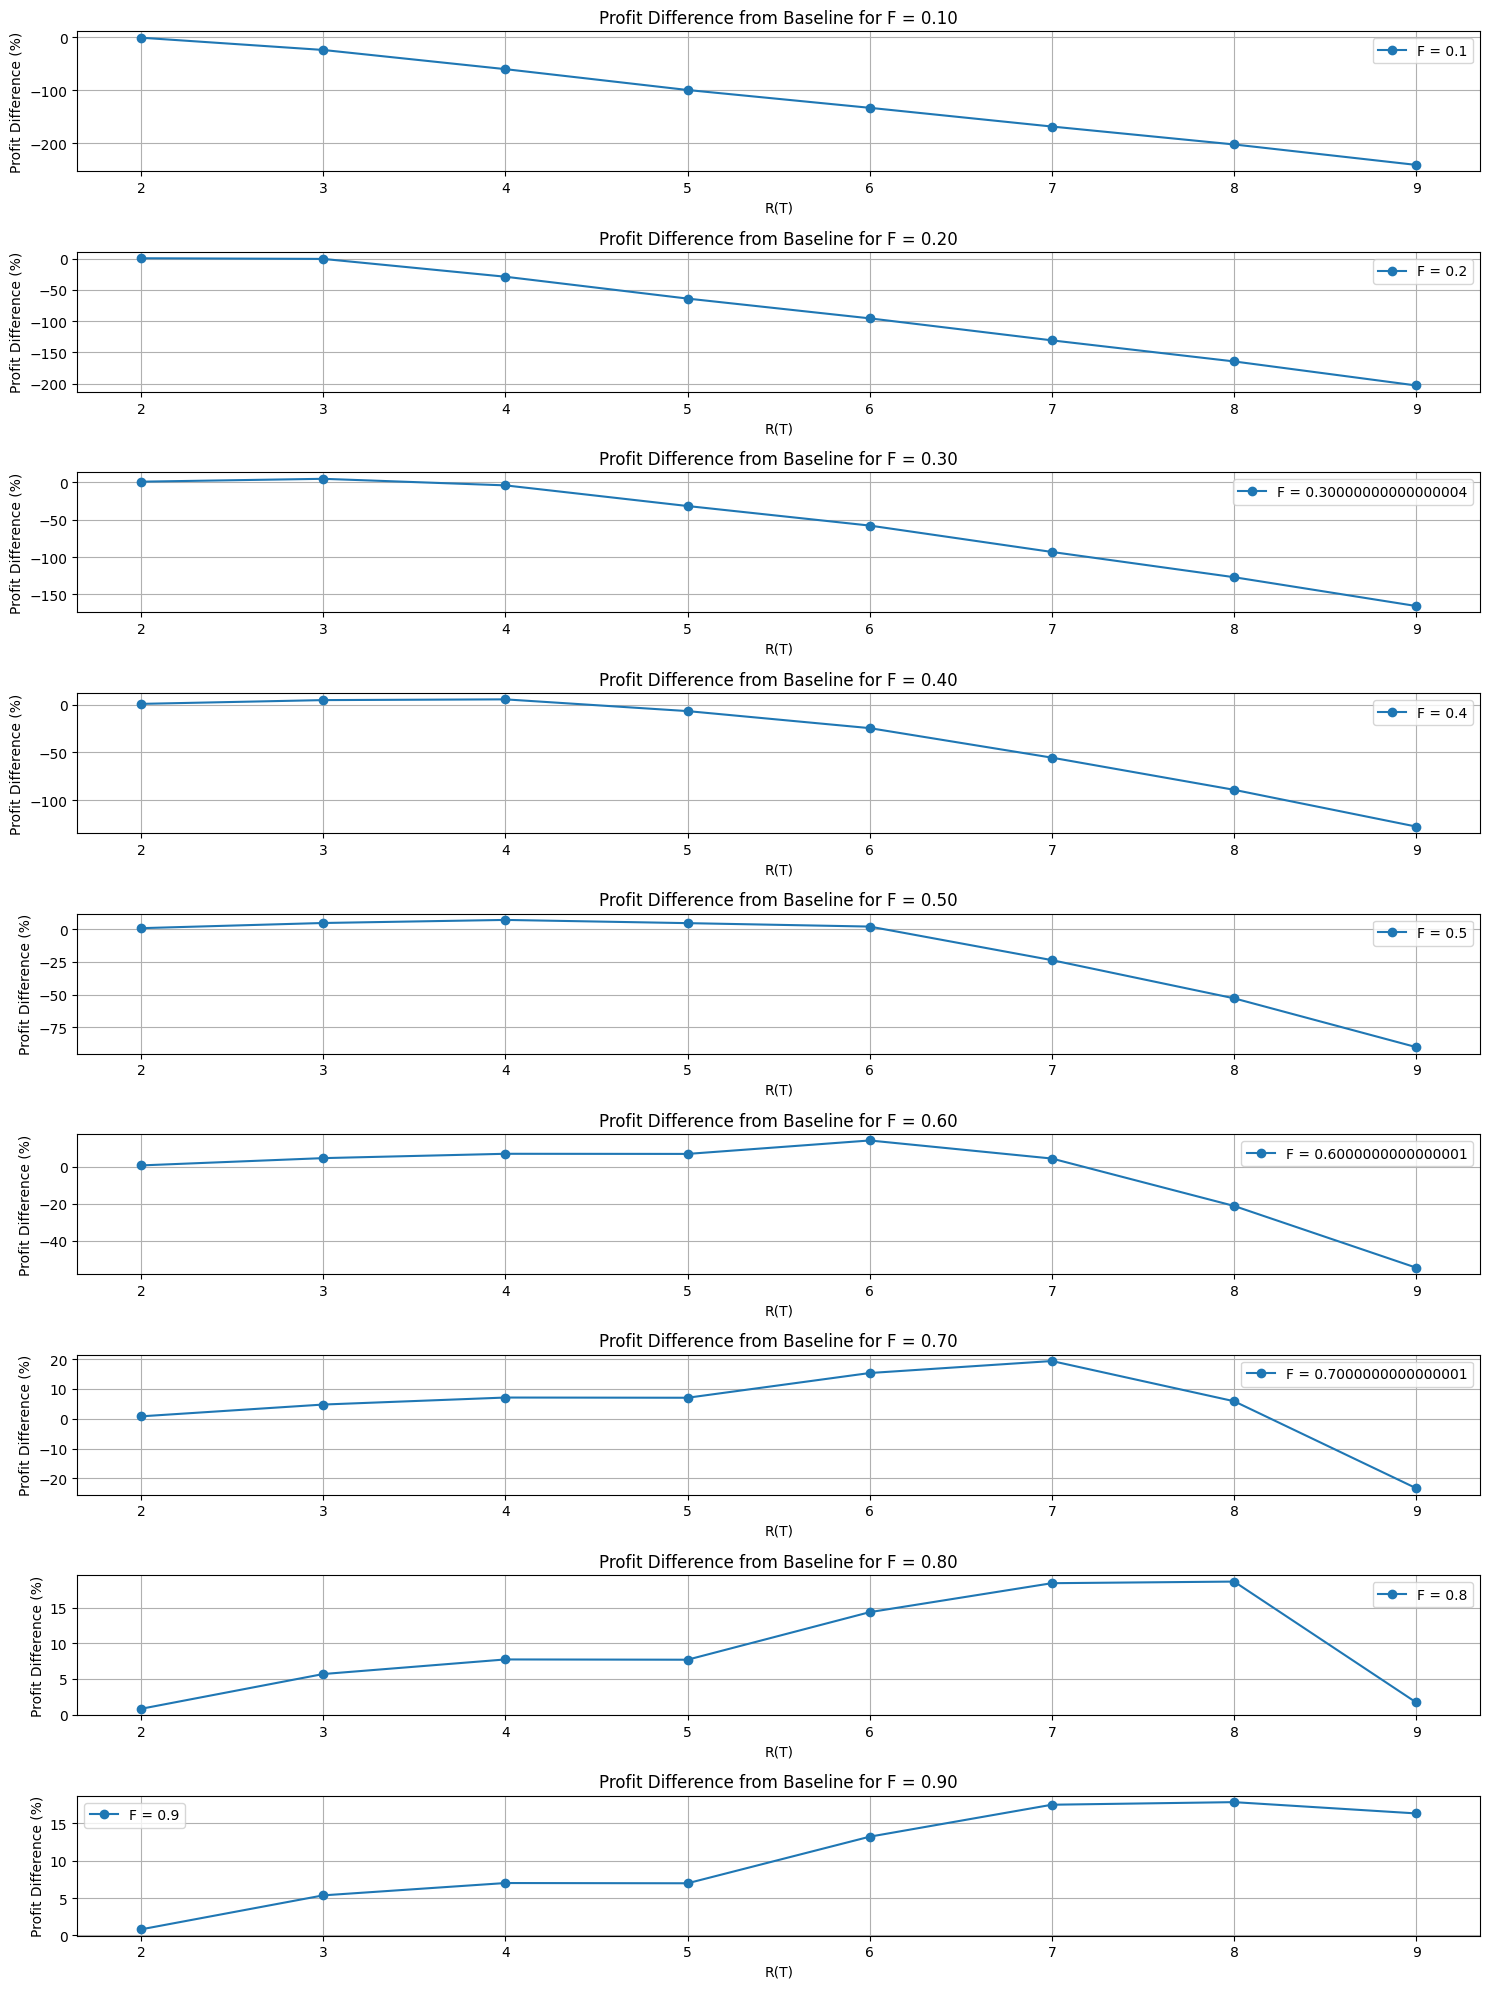

In [101]:
results_df_8["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_8["profit_diff_percent"] = (
    (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [102]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 840 rows, 703 columns and 2640 nonzeros
Model fingerprint: 0x57ad5964
Model has 40 general constraints
Variable types: 403 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 5e+06]
Presolve removed 746 rows and 432 columns
Presolve time: 0.00s
Presolved: 94 rows, 271 columns, 760 nonzeros
Presolved model has 20 SOS constraint(s)
Variable types: 261 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1556107.26    0   18          - 1556107.26      -     -    0s
     0     0 1556107.25    0   18          - 1556107.25      -     -    0s
     0     0 1556107.20    0   17          - 1556107.20      -     -    0s
     0     0 1556106.84    0   17          - 1556106.84      -     -    0s
     0     0 1556106.23    0   17          - 1556106.23      -     -    0s
     0     0 1556106.23    0   17          - 1556106.23      -     -    0s
     0     0 1556106.23    0   17          - 1556106.23      -     -    0s
     0     0 1556106.23    0   17          - 1556106.23      -     -    0s
     0     0 1556106.23    0   17          - 1556106.23      -     -    0s
H    0     0                    1515200.1044 1556106.23  2.70%     -    0s

Explored 1 nodes (152 simplex iterations) in 0.07 seconds (0.01 work units)
Thread count was 12 (

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1587718.07    0   19          - 1587718.07      -     -    0s
     0     0 1587718.07    0   16          - 1587718.07      -     -    0s
     0     0 1587718.05    0   16          - 1587718.05      -     -    0s
     0     0 1587717.89    0   16          - 1587717.89      -     -    0s
     0     0 1587717.63    0   16          - 1587717.63      -     -    0s
     0     0 1587717.63    0   16          - 1587717.63      -     -    0s
     0     0 1587717.63    0   16          - 1587717.63      -     -    0s
     0     0 1587717.63    0   16          - 1587717.63      -     -    0s
     0     0 1587717.28    0   16          - 1587717.28      -     -    0s
H    0     0                    1534689.6394 1587717.28  3.46%     -    0s

Explored 1 nodes (157 simplex iterations) in 0.10 seconds (0.01 work units)
Thread count was 12 (

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        4         4         4         2         2         2           0s

IIS computed: 4 constraints, 2 bounds
IIS runtime: 0.62 seconds (0.05 work units)
導致不可行的約束： Set_R_4_0_To_1
導致不可行的約束： Define_Q_hat_4
導致不可行的約束： Adjust_Q_hat_4
導致不可行的變量： Q0_var[4], IIS下界： 0, IIS上界： 1
導致不可行的變量： Q1_var[4], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is T=7 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 840 rows, 703 columns and 2640 nonzeros
Model fingerprint: 0xe144f8da
Model has 40 general constraints
Variable types: 403 continuous, 300 integer (300 binary)
Coefficient

R(T)                                                  R  average_profits  \
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     76734.481971   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     76685.371721   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     75760.005219   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     73413.402436   

   average_losses  average_lefts  average_operation_profits  \
3        7.338849     117.746797               87512.349076   
2        7.358923     137.370934               87502.312335   
1        8.363778     157.701622               86999.884957   
0       11.416443     176.208856               85473.552124   

                                        alpha_values  \
3       [0.8838223148726989, 0.0, 9.785315808654634]   
2       [0.8838223148726989, 0.0, 9.785315808654634]   
1  [285114.93248218496, 165501.5896621202, 678060...   
0  [285114.93248218496, 165501.58966212015, 67806...   

                                              F_vars  \
3  [0.9996646508350594, 0.9999516394164341, 0.999...   
2  [0.9996646508350595, 0.9999516394164341, 0.999...   
1  [0.999954988325889, 0.999995027723146, 0.99995...   
0  [0.999954988325889, 0.999995027723146, 0.99995...   

                                             Q0_vars  \
3  [182.30239215289626, 182.35472840872112, 182.3...   
2  [182.3023921528963, 182.35472840872112, 182.30...   
1  [182.35533912772996, 182.36264085425816, 182.3...   
0  [182.35533912772996, 182.36264085425816, 182.3...   

                                             Q1_vars  
3  [4.508373549141957, 6.574756158976557, 7.10724...  
2  [4.673210650083785, 6.810382845124035, 6.90883...  
1  [4.566008324647017, 13.107115708723267, 1.2829...  
0  [4.505080936859266, 2.195355733153519, 0.0, 3....

In [103]:
stimulation_results_df_2

R(T)  R         F       profits     losses       lefts  operation_profits  \
0      5  3  0.999665  89587.164645   7.636436   89.691976       93405.382851   
1      5  3  0.999952  88357.830155  12.213824   85.928398       94464.742284   
2      5  3  0.999665  79268.103878  30.873426  108.157638       94704.816810   
3      5  3  0.999665  34554.403569   0.000000  161.350646       62852.799779   
4      5  3  0.999665  98915.441238   8.760954  108.691598      103295.917998   
5      5  3  0.999665  83383.166908  27.441010  107.374573       97103.672119   
6      5  3  0.999665  93877.765152   0.000000  101.789725       98581.130215   
7      5  3  0.999952  81505.942442  19.342844  101.949201       91177.364205   
8      5  3  0.999665  54128.667217   0.000000  139.726520       73221.144010   
9      5  3  0.999665  95803.850596   0.000000  113.606756       96741.203587   
10     5  3  0.999952  85059.739914  12.235249   97.990312       91177.364206   
11     5  3  0.999665  30961.127621   0.000000  182.974642       61056.161807   
12     5  3  0.999665  66053.744520   0.000000  135.871263       78602.470273   
13     5  3  0.999665  81009.623954   0.000000   97.672472       86080.410008   
14     5  3  0.999665  82562.932654  17.176527  116.268263       91151.196063   
15     5  3  0.999665  93407.431601  11.096720   76.909616       98955.791546   
16     5  3  0.999665  69821.631527   0.000000  127.442059       80486.413774   
17     5  3  0.999665  82793.521477   0.000000   95.863654       93415.103379   
18     5  3  0.999665  84564.013932   0.000000  122.241118       88661.530370   
19     5  3  0.999665  59073.536428   0.000000  183.435515       75112.366233   

            Q0         Q1         hc0  ...   demand_up  demand_down  \
0   182.302392   4.508374  553.005483  ...   92.610416   101.836786   
1   182.354728   6.574756  549.715765  ...   96.426330   104.716978   
2   182.302392   7.107241  595.134544  ...   74.144754   146.138306   
3   182.302392   0.000000  574.112491  ...   77.548539    48.157061   
4   182.302392  24.289444  630.566869  ...   73.610794   141.741996   
5   182.302392  11.904952  603.163834  ...   74.927819   146.720536   
6   182.302392  24.266599  597.903970  ...   89.919397   107.242863   
7   182.354728   0.000000  568.607859  ...   80.405527   121.292045   
8   182.302392   2.324850  572.337615  ...   80.760826    65.681462   
9   182.302392  13.054721  614.178326  ...   70.570342   122.912065   
10  182.354728   0.000000  560.690082  ...   84.364416   110.225561   
11  182.302392   0.000000  610.173931  ...   59.517819    62.594505   
12  182.302392   0.000000  586.152408  ...   71.528580    85.676360   
13  182.302392   0.000000  539.666585  ...   94.771492    77.389328   
14  182.302392   0.000000  597.141311  ...   66.034129   133.444790   
15  182.302392  15.609191  549.642399  ...  105.392776   103.615527   
16  182.302392   0.000000  576.829774  ...   76.189897    84.782930   
17  182.302392  25.770978  565.387722  ...  107.681902    79.148305   
18  182.302392   3.215702  599.128357  ...   68.256307   109.066754   
19  182.302392   0.000000  667.320496  ...   30.944536   119.280196   

        Sold0s      Sold1s      Left0s     Left1s  lost0s     lost1s  \
0    92.610416   94.200349   89.691976   0.000000     0.0   7.636436   
1    96.426330   92.503154   85.928398   0.000000     0.0  12.213824   
2    74.144754  115.264880  108.157638   0.000000     0.0  30.873426   
3    77.548539   48.157061  104.753853  56.596792     0.0   0.000000   
4    73.610794  132.981042  108.691598   0.000000     0.0   8.760954   
5    74.927819  119.279525  107.374573   0.000000     0.0  27.441010   
6    89.919397  107.242863   92.382995   9.406730     0.0   0.000000   
7    80.405527  101.949201  101.949201   0.000000     0.0  19.342844   
8    80.760826   65.681462  101.541566  38.184954     0.0   0.000000   
9    70.570342  122.912065  111.732050   1.874706     0.0   0.000000   
10   84.364416   9

In [104]:
stimulation_results_df_2_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_2, Q_star, Qk_hat_df_train
)
stimulation_results_df_2_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0   3  182.363548  0.999665  182.302392   92.610416   92.610416   89.691976   
1   3  182.363548  0.999952  182.354728   96.426330   96.426330   85.928398   
2   3  182.363548  0.999665  182.302392   74.144754   74.144754  108.157638   
3   3  182.363548  0.999665  182.302392   77.548539   77.548539  104.753853   
4   3  182.363548  0.999665  182.302392   73.610794   73.610794  108.691598   
5   3  182.363548  0.999665  182.302392   74.927819   74.927819  107.374573   
6   3  182.363548  0.999665  182.302392   89.919397   89.919397   92.382995   
7   3  182.363548  0.999952  182.354728   80.405527   80.405527  101.949201   
8   3  182.363548  0.999665  182.302392   80.760826   80.760826  101.541566   
9   3  182.363548  0.999665  182.302392   70.570342   70.570342  111.732050   
10  3  182.363548  0.999952  182.354728   84.364416   84.364416   97.990312   
11  3  182.363548  0.999665  182.302392   59.517819   59.517819  122.784573   
12  3  182.363548  0.999665  182.302392   71.528580   71.528580  110.773812   
13  3  182.363548  0.999665  182.302392   94.771492   94.771492   87.530900   
14  3  182.363548  0.999665  182.302392   66.034129   66.034129  116.268263   
15  3  182.363548  0.999665  182.302392  105.392776  105.392776   76.909616   
16  3  182.363548  0.999665  182.302392   76.189897   76.189897  106.112495   
17  3  182.363548  0.999665  182.302392  107.681902  107.681902   74.620491   
18  3  182.363548  0.999665  182.302392   68.256307   68.256307  114.046085   
19  3  182.363548  0.999665  182.302392   30.944536   30.944536  151.357856   

    lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  \
0      0.0  186.810766   4.508374  ...   0.000000   7.636436   
1      0.0  188.929485   6.574756  ...   0.000000  12.213824   
2      0.0  189.409634   7.107241  ...   0.000000  30.873426   
3      0.0  151.130876 -31.171516  ...  56.596792   0.000000   
4      0.0  206.591836  24.289444  ...   0.000000   8.760954   
5      0.0  194.207344  11.904952  ...   0.000000  27.441010   
6      0.0  206.568991  24.266599  ...   9.406730   0.000000   
7      0.0  166.153318 -16.201410  ...   0.000000  19.342844   
8      0.0  184.627242   2.324850  ...  38.184954   0.000000   
9      0.0  195.357113  13.054721  ...   1.874706   0.000000   
10     0.0  181.717947  -0.636782  ...   0.000000  12.235249   
11     0.0  180.674267  -1.628125  ...  60.190068   0.000000   
12     0.0  161.502581 -20.799811  ...  25.097452   0.000000   
13     0.0  176.921635  -5.380757  ...  10.141572   0.000000   
14     0.0  181.232901  -1.069491  ...   0.000000  17.176527   
15     0.0  197.911583  15.609191  ...   0.000000  11.096720   
16     0.0  167.460099 -14.842293  ...  21.329564   0.000000   
17     0.0  208.073371  25.770978  ...  21.243164   0.000000   
18     0.0  185.518094   3.215702  ...   8.195033   0.000000   
19     0.0  136.471871 -45.830521  ...  32.077660   0.000000   

    Q0-Sold0s(left0)  demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0          89.691976           -89.691976                -1.862645e-09   
1          85.928398           -85.928398                -1.862645e-09   
2         108.157638          -108.157638                -1.862645e-09   
3         104.753853          -104.753853                 5.659679e+01   
4         108.691598          -108.691598                -1.862645e-09   
5         107.374573          -107.374573                -1.862645e-09   
6          92.382995           -92.382995                 9.406730e+00   
7         101.949201          -101.949201                 0.000000e+00   
8         101.541566          -101.541566                 3.818495e+01   
9         111.732050          -111.732050                 1.874706e+00   
10         97.990312           -97.990312                 0.000000e+00   
11        122.784573          -122.784573                 6.019007e+01   
12        110.773812          -110.77

In [105]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

In [106]:
# # 驗證 Q1 計算是否正確

# if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
#     stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
#         :, stimulation_results_df_2.iloc[0, 0]
#     ]
#     stimulation_results_df_2["Qk_hat-Q0"] = (
#         stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
#     )
#     stimulation_results_df_2["Q_star"] = Q_star
#     print(
#         stimulation_results_df_2[
#             ["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]
#         ]
#     )

In [107]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s2_40_202411271920.pkl


In [108]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
3     5     76734.481971
2     4     76685.371721
1     3     75760.005219

### S3 - Grid for Fixed F & Flexible Rk


In [109]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
    assigned_Fs=ASSIGNED_FS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)


results_df_3

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1200 rows, 1364 columns and 3840 nonzeros
Model fingerprint: 0x0fa69b2d
Model has 200 quadratic constraints
Model has 360 general constraints
Variable types: 1064 continuous, 300 integer (280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e-01, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 440 rows an

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/2035653732.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        6         6         6         1         1         1           5s

IIS computed: 6 constraints, 1 bounds
IIS runtime: 4.54 seconds (0.74 work units)
導致不可行的約束： R660
導致不可行的約束： Q0_upper_bound_11
導致不可行的約束： Ensure_only_one_R_true_11
導致不可行的約束： Define_Q_hat_11
導致不可行的約束： Adjust_Q_hat_11
導致不可行的變量： Q1_var[11], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is F=0.2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1200 rows, 1364 columns and 3840 nonzeros
Model fingerprint: 0x2853ef8d
Model has 200 quadratic constraints
Model has 360 general constraints
Variable t

Empty DataFrame
Columns: [R(T), average_losses, average_lefts, average_operation_profits, average_profits, beta_values, F_vars, Q0_vars, Q1_vars, tau_values]
Index: []

In [110]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [111]:
stimulation_results_df_3_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_3, Q_star, Qk_hat_df_train
)
stimulation_results_df_3_selected

In [112]:
rounded_difference_df

In [113]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [ ]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1200 rows, 1395 columns and 3580 nonzeros
Model fingerprint: 0x49486e91
Model has 200 quadratic constraints
Model has 380 general constraints
Variable types: 1095 continuous, 300 integer (280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 259 rows and 24966 columns
Presolve time: 0.15s
Presolved: 7819 rows, 27861 columns, 96879 nonzeros
Presolved model

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_33815/104858953.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Variable types: 27452 continuous, 409 integer (389 binary)

Root relaxation: objective 1.813946e+06, 1274 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1813945.81    0 1174          - 1813945.81      -     -    0s
     0     0 1813945.81    0 1173          - 1813945.81      -     -    0s
     0     0 1813945.81    0 1173          - 1813945.81      -     -    0s
     0     0 1813945.81    0 1173          - 1813945.81      -     -    0s
     0     0 1813945.80    0 1173          - 1813945.80      -     -    0s
     0     0 1813588.78    0 1470          - 1813588.78      -     -    0s
     0     0 1813588.78    0 1469          - 1813588.78      -     -    0s
     0     0 1813588.78    0 1469          - 1813588.78      -     -    0s
     0     0 1813588.78    0 1469          - 1813588.78      -     -    1s
     0     0 1813588.78 

In [ ]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s5_40_202411271120.pkl


In [ ]:
stimulation_results_df_5

R(T)  R         F  f_values        profits  losses       lefts  \
0      9  7  0.999665  8.193627   96853.795006     0.0   21.006160   
1      8  6  0.993307  5.646288   99641.414539     0.0   42.563618   
2      6  4  0.998967  7.346858  107506.070195     0.0   88.551727   
3      9  7  0.578230  0.410875   61372.230124     0.0    2.961139   
4      7  5  0.982014  4.940834  105956.274135     0.0   63.235631   
5      9  7  0.999542  7.885585  107092.121594     0.0   17.172436   
6      6  4  0.977876  3.918232   98232.686107     0.0   75.300531   
7      7  5  0.993307  6.277382   98381.992499     0.0   58.952772   
8      9  7  0.653500  1.069491   72145.126045     0.0    2.152036   
9      3  1  0.989284  4.937288   90204.682644     0.0  156.022555   
10     9  7  0.993307  6.815117   95641.519023     0.0   21.168587   
11     6  4  0.500000  0.841090   61028.489667     0.0   27.976249   
12     7  5  0.969320  3.749172   68820.642796     0.0  107.931311   
13     2  0  0.997527  6.872452   81194.799428     0.0  173.431379   
14     7  5  0.998641  7.042116   99547.588621     0.0   69.729580   
15     9  7  0.997527  7.687402  103501.500322     0.0   15.146609   
16     9  7  0.944364  3.256050   74864.070128     0.0   39.415761   
17     7  5  0.999665  8.358938   93375.882299     0.0   59.541421   
18     8  6  0.962926  4.726350   87801.311533     0.0   67.269073   
19     3  1  0.823765  4.762145   75112.366233     0.0  134.583666   

    operation_profits          Q0         Q1  ...      Left0s     Left1s  \
0        97223.601057  182.302392  12.884422  ...   20.266548   0.739612   
1        99641.414539  181.143016  18.139813  ...   42.563618   0.000000   
2       107506.070195  182.175108  32.837033  ...   88.551727   0.000000   
3        61372.230124  105.448075  17.296386  ...    2.961139   0.000000   
4       105956.274135  179.083519  32.829029  ...   63.235631   0.000000   
5       107092.121594  182.280095  31.904148  ...   17.172436   0.000000   
6        98581.130215  178.328872  19.530276  ...   74.603643   0.696888   
7       100848.785969  181.143017  25.488142  ...   54.019185   4.933587   
8        73221.144010  119.174668  29.419655  ...    0.000000   2.152036   
9        90204.682644  180.409365   0.000000  ...  156.022555   0.000000   
10       97294.988499  181.143018  16.753898  ...   17.861648   3.306939   
11       61028.489667   91.181851  30.875129  ...   27.976249   0.000000   
12       78602.470273  176.768595   0.000000  ...   88.367656  19.563655   
13       86080.410008  181.912634   0.019407  ...  163.660158   9.771221   
14       99547.588621  182.115719  16.979458  ...   69.729580   0.000000   
15      104504.151491  181.912632  29.100973  ...   13.141307   2.005302   
16       80486.413774  172.217515   0.000000  ...   28.171074  11.244687   
17       93415.103379  182.302392   4.606257  ...   59.462978   0.078442   
18       87801.311533  175.602623   0.000000  ...   67.269073   0.000000   
19       75112.366233  150.224732   0.000000  ...  134.583666   0.000000   

    lost0s  lost1s      Qk_hat      Sold0s      Sold1s   demand_up  \
0      0.0     0.0  195.186814  162.035844   32.411358  162.035844   
1      0.0     0.0  199.282829  138.579397   60.703432  140.439877   
2      0.0     0.0  215.012140   93.623380  121.388760   98.894299   
3      0.0     0.0  122.744460  102.486935   20.257525  105.448075   
4      0.0     0.0  211.912548  115.847887   96.064661  119.288129   
5      0.0     0.0  214.184243  165.107659   49.076584  172.571770   
6      0.0     0.0  197.859149  103.725229   93.437031  103.725229   
7      0.0     0.0  206.631159  127.123832   74.573740  127.123832   
8      0.0     0.0  148.594324  119.174668   27.267620  119.174668   
9      0.0     0.0  180.017011   24.386810  156.022555   37.459852   
10     0.0     0.0  197.896916  163.281370   31.308607  163.281370   
11     0.0     0.0  122.056979   63.205601   58.851378   63.260946   
12     0.0     0.0  144.59

In [ ]:
stimulation_results_df_5_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_5, Q_star, Qk_hat_df_train
)
stimulation_results_df_5_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0   7  182.363548  0.999665  182.302392  162.035844  162.035844   20.266548   
1   6  182.363548  0.993307  181.143016  140.439877  138.579397   42.563618   
2   4  182.363548  0.998967  182.175108   98.894299   93.623380   88.551727   
3   7  182.363548  0.578230  105.448075  105.448075  102.486935    2.961139   
4   5  182.363548  0.982014  179.083519  119.288129  115.847887   63.235631   
5   7  182.363548  0.999542  182.280095  172.571770  165.107659   17.172436   
6   4  182.363548  0.977876  178.328872  103.725229  103.725229   74.603643   
7   5  182.363548  0.993307  181.143017  127.123832  127.123832   54.019185   
8   7  182.363548  0.653500  119.174668  119.174668  119.174668    0.000000   
9   1  182.363548  0.989284  180.409365   37.459852   24.386810  156.022555   
10  7  182.363548  0.993307  181.143018  163.281370  163.281370   17.861648   
11  4  182.363548  0.500000   91.181851   63.260946   63.205601   27.976249   
12  5  182.363548  0.969320  176.768595   88.400939   88.400939   88.367656   
13  0  182.363548  0.997527  181.912634   18.252477   18.252477  163.660158   
14  5  182.363548  0.998641  182.115719  112.769881  112.386139   69.729580   
15  7  182.363548  0.997527  181.912632  168.771325  168.771325   13.141307   
16  7  182.363548  0.944364  172.217515  144.046441  144.046441   28.171074   
17  5  182.363548  0.999665  182.302392  122.839414  122.839414   59.462978   
18  6  182.363548  0.962926  175.602623  110.053988  108.333550   67.269073   
19  1  182.363548  0.823765  150.224732   15.641067   15.641067  134.583666   

    lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s  lost1s  Q0-Sold0s(left0)  \
0      0.0  195.186814  12.884422  ...   0.739612     0.0         20.266548   
1      0.0  199.282829  18.139813  ...   0.000000     0.0         42.563618   
2      0.0  215.012140  32.837033  ...   0.000000     0.0         88.551727   
3      0.0  122.744460  17.296386  ...   0.000000     0.0          2.961139   
4      0.0  211.912548  32.829029  ...   0.000000     0.0         63.235631   
5      0.0  214.184243  31.904148  ...   0.000000     0.0         17.172436   
6      0.0  197.859149  19.530276  ...   0.696888     0.0         74.603643   
7      0.0  206.631159  25.488142  ...   4.933587     0.0         54.019185   
8      0.0  148.594324  29.419655  ...   2.152036     0.0          0.000000   
9      0.0  180.017011  -0.392354  ...   0.000000     0.0        156.022555   
10     0.0  197.896916  16.753898  ...   3.306939     0.0         17.861648   
11     0.0  122.056979  30.875129  ...   0.000000     0.0         27.976249   
12     0.0  144.594738 -32.173858  ...  19.563655     0.0         88.367656   
13     0.0  181.932041   0.019407  ...   9.771221     0.0        163.660158   
14     0.0  199.095177  16.979458  ...   0.000000     0.0         69.729580   
15     0.0  211.013605  29.100973  ...   2.005302     0.0         13.141307   
16     0.0  163.113600  -9.103915  ...  11.244687     0.0         28.171074   
17     0.0  186.908649   4.606257  ...   0.078442     0.0         59.462978   
18     0.0  175.602623   0.000000  ...   0.000000     0.0         67.269073   
19     0.0  132.501730 -17.723003  ...   0.000000     0.0        134.583666   

    demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0            -20.266548                     0.739612   
1            -40.703139                     0.000000   
2            -83.280808                     0.000000   
3              0.000000                     0.000000   
4            -59.795390                     0.000000   
5             -9.708324                     0.000000   
6            -74.603643                     0.696888   
7            -54.019185                     4.933587   
8              0.000000                     2.152036   
9           -142.949514                     0.000000   
10           -17.861648                     3.306939   
11          

In [ ]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                 0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [ ]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)



/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/3055309810.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1200 rows, 1351 columns and 3820 nonzeros
Model fingerprint: 0xe42e9db7
Model has 180 quadratic constraints
Model has 360 general constraints
Variable types: 1051 continuous, 300 integer (280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 239 rows and 21889 columns
Presolve time: 0.39s
Presolved: 2279 rows, 23300 columns, 71959 nonzeros
Presolved model has 160 SOS constraint(s)
Presolved model has 200 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 22891 continuous, 409 integer (389 binary)

Root relaxation: objective 1.8

average_profits  average_losses  average_lefts  average_operation_profits  \
0     89650.658178             0.0      35.561973               90435.199477   

                                        alpha_values  \
0  [1.061532339774418, 0.1852969302635481, 2.6695...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [ ]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s6_40_202411271120.pkl


In [ ]:
stimulation_results_df_6_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_6, Q_star, Qk_hat_df_train
)
stimulation_results_df_6_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s     Left0s  \
0   7  182.363548  0.999660  182.301626  162.035844  162.035844  20.265782   
1   6  182.363548  0.953812  173.940526  140.439877  138.579397  35.361129   
2   4  182.363548  0.999660  182.301576   98.894299   93.623380  88.678196   
3   7  182.363548  0.578230  105.448075  105.448075  102.486935   2.961139   
4   7  182.363548  0.999659  182.301423  160.095116  159.586921  22.714502   
5   5  182.363548  0.965781  176.123228  120.496590  107.766995  68.356233   
6   4  182.363548  0.904907  165.022116  103.725229  103.725229  61.296886   
7   7  182.363548  0.949786  173.206267  173.206267  172.811271   0.394996   
8   7  182.363548  0.653500  119.174668  119.174668  119.174668   0.000000   
9   7  182.363548  0.928210  169.271734  154.596800  154.596800  14.674934   
10  5  182.363548  0.965174  176.012507  122.226048  122.226048  53.786458   
11  4  182.363548  0.489242   89.219946   63.260946   63.205601  26.014345   
12  7  182.363548  0.669805  122.148025  115.917401  113.697519   8.450506   
13  6  182.363548  0.943309  172.025105  131.310225  131.174510  40.850595   
14  5  182.363548  0.911685  166.258144  112.769881  112.386139  53.872005   
15  7  182.363548  0.999660  182.301602  168.771325  168.771325  13.530277   
16  7  182.363548  0.789886  144.046441  144.046441  144.046441   0.000000   
17  6  182.363548  0.982014  179.083519  129.538890  127.916361  51.167157   
18  6  182.363548  0.782863  142.765590  110.053988  108.333550  34.432040   
19  5  182.363548  0.903253  164.720418   81.669791   81.669791  83.050627   

    lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s  lost1s  Q0-Sold0s(left0)  \
0      0.0  195.186814  12.885188  ...   0.739612     0.0         20.265782   
1      0.0  199.282829  25.342303  ...   0.000000     0.0         35.361129   
2      0.0  215.012140  32.710565  ...   0.000000     0.0         88.678196   
3      0.0  122.744460  17.296386  ...   0.000000     0.0          2.961139   
4      0.0  214.844595  32.543171  ...   0.000000     0.0         22.714502   
5      0.0  208.918760  32.795532  ...   0.000000     0.0         68.356233   
6      0.0  197.859149  32.837033  ...   0.696888     0.0         61.296886   
7      0.0  201.302576  28.096310  ...   0.000000     0.0          0.394996   
8      0.0  148.594324  29.419655  ...   2.152036     0.0          0.000000   
9      0.0  194.801368  25.529635  ...   1.318961     0.0         14.674934   
10     0.0  202.422372  26.409865  ...   7.832395     0.0         53.786458   
11     0.0  122.056979  32.837033  ...   0.000000     0.0         26.014345   
12     0.0  154.985058  32.837033  ...   0.000000     0.0          8.450506   
13     0.0  169.763996  -2.261109  ...   0.000000     0.0         40.850595   
14     0.0  199.095177  32.837033  ...   0.000000     0.0         53.872005   
15     0.0  211.013605  28.712003  ...   2.005302     0.0         13.530277   
16     0.0  163.113600  19.067159  ...   2.140772     0.0          0.000000   
17     0.0  185.207678   6.124159  ...   0.000000     0.0         51.167157   
18     0.0  175.602623  32.837033  ...   0.000000     0.0         34.432040   
19     0.0  143.552963 -21.167454  ...  14.495685     0.0         83.050627   

    demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0            -20.265782                     0.739612   
1            -33.500650                     0.000000   
2            -83.407276                     0.000000   
3              0.000000                     0.000000   
4            -22.206307                     0.000000   
5            -55.626639                     0.000000   
6            -61.296886                     0.696888   
7              0.000000                     0.000000   
8              0.000000                     2.152036   
9            -14.674934                     1.318961   
10           -53.786458                     7.832395   
11           -25.959001          

In [ ]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                 0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                 0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [ ]:
results_df_7, stimulation_results_df_7 = None, None
# results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
#     holding_cost=holding_cost,
# )
# results_df_7

In [ ]:
if results_df_7 is not None:

    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [ ]:
stimulation_results_df_7

In [ ]:
stimulation_results_df_7_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_7, Q_star, Qk_hat_df_train
)
stimulation_results_df_7_selected

In [ ]:
rounded_difference_df

#### S4 - Beta with softmax


In [ ]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1200 rows, 1387 columns and 3900 nonzeros
Model fingerprint: 0x44f2532e
Model has 200 quadratic constraints
Model has 380 general constraints
Variable types: 1087 continuous, 300 integer (280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/853573315.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 419 rows and 25150 columns
Presolve time: 0.43s
Presolved: 5519 rows, 27417 columns, 90179 nonzeros
Presolved model has 180 SOS constraint(s)
Presolved model has 900 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 27008 continuous, 409 integer (389 binary)

Root relaxation: objective 1.813946e+06, 2038 iterations, 0.09 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1813945.66    0  696          - 1813945.66      -     -    0s
     0     0 1813945.66    0  695          - 1813945.66      -     -    0s
     0     0 1813945.66    0  695          - 1813945.66      -     -    1s
     0     0 1813945.66    0  695          - 1813945.66      -     -    1s
     0     0 1813945.65    0  695          - 1813945.65      -     -    1s
     0     0 1813369.40    0  806          - 1813369.40      -     -    1s
     0     0 18133

In [ ]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

In [ ]:
stimulation_results_df_4_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_4, Q_star, Qk_hat_df_train
)
stimulation_results_df_4_selected

In [ ]:
rounded_difference_df

### Analysis


#### Baseline


In [ ]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 72674.63967636268


#### S1


In [ ]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
51     7  0.7  [127.65448333141352, 127.65448333141352, 127.6...   
61     8  0.8  [145.890838093044, 145.890838093044, 145.89083...   
52     7  0.8  [145.890838093044, 145.890838093044, 145.89083...   
62     8  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
53     7  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
..   ...  ...                                                ...   
65     9  0.3  [54.70906428489151, 54.70906428489151, 54.7090...   
45     7  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
54     8  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
64     9  0.2  [36.472709523261, 36.472709523261, 36.47270952...   
63     9  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   

                                                   Q1  average_profits  \
51  [64.51404043268859, 68.45966069061639, 93.6345...     86755.774250   
61  [47.39010572765039, 53.39199098539328, 70.3951...     86237.185406   
52  [46.277685671058094, 50.223305928985894, 75.39...     86073.410749   
62  [29.153750966019913, 35.1556362237628, 52.1587...     85643.584594   
53  [28.041330909427614, 31.986951167355414, 57.16...     85391.984653   
..                                                ...              ...   
65  [140.47774993342927, 142.1244237253428, 164.03...    -47572.365302   
45  [173.9321690024716, 177.8777892603994, 203.052...    -49735.225196   
54  [175.0445890590639, 181.04647431680678, 198.04...    -74269.786646   
64  [158.71410469505975, 160.3607784869733, 182.27...    -74926.897445   
63  [176.95045945669025, 178.5971332486038, 200.51...   -102281.429587   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
51        2.816963       3.218074               89773.292488     72674.639676   
61        2.484468       4.920242               89939.539994     72674.639676   
52        2.604147       5.008433               89879.700539     72674.639676   
62        1.744346       7.587686               90309.600614     72674.639676   
53        1.821747       7.936085               90270.900460     72674.639676   
..             ...            ...                        ...              ...   
65       92.502759      92.502759               44930.394105     72674.639676   
45       93.944666      93.944666               44209.440807     72674.639676   
54      110.301040     110.301040               36031.253657     72674.639676   
64      110.739114     110.739114               35812.216724     72674.639676   
63      128.975469     128.975469               26694.039343     72674.639676   

    profit_diff_percent  
51            19.375582  
61            18.662006  
52            18.436653  
62            17.845214  
53            17.499013  
..                  ...  
65          -165.459376  
45          -168.435462  
54          -202.194916  
64          -203.099097  
63          -240.738819  

[72 rows x 10 columns]

In [ ]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]

    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1最佳策略在：R=7, F=0.7000000000000001
策略1最佳策略之下最大利潤為：86755.77424978417


#### S2


In [ ]:
results_df_2

R(T)                                                  R  average_profits  \
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     76734.481971   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     76685.371721   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     75760.005219   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     73413.402436   

   average_losses  average_lefts  average_operation_profits  \
3        7.338849     117.746797               87512.349076   
2        7.358923     137.370934               87502.312335   
1        8.363778     157.701622               86999.884957   
0       11.416443     176.208856               85473.552124   

                                        alpha_values  \
3       [0.8838223148726989, 0.0, 9.785315808654634]   
2       [0.8838223148726989, 0.0, 9.785315808654634]   
1  [285114.93248218496, 165501.5896621202, 678060...   
0  [285114.93248218496, 165501.58966212015, 67806...   

                                              F_vars  \
3  [0.9996646508350594, 0.9999516394164341, 0.999...   
2  [0.9996646508350595, 0.9999516394164341, 0.999...   
1  [0.999954988325889, 0.999995027723146, 0.99995...   
0  [0.999954988325889, 0.999995027723146, 0.99995...   

                                             Q0_vars  \
3  [182.30239215289626, 182.35472840872112, 182.3...   
2  [182.3023921528963, 182.35472840872112, 182.30...   
1  [182.35533912772996, 182.36264085425816, 182.3...   
0  [182.35533912772996, 182.36264085425816, 182.3...   

                                             Q1_vars  
3  [4.508373549141957, 6.574756158976557, 7.10724...  
2  [4.673210650083785, 6.810382845124035, 6.90883...  
1  [4.566008324647017, 13.107115708723267, 1.2829...  
0  [4.505080936859266, 2.195355733153519, 0.0, 3....

In [ ]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]

    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2最佳策略在：R=5, F為彈性
策略2最佳策略之下最大利潤為：76734.48197139922


#### S3


In [ ]:
# 策略三
results_df_3

In [ ]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = results_df_3.iloc[0]
    max_profit_for_s3 = max_profit_row["average_profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['F_vars'][0]}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [ ]:
results_df_4

In [ ]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [ ]:
results_df_5

average_profits  average_losses  average_lefts  average_operation_profits  \
0     88913.728147             0.0      62.205612               90276.037398   

                                   alpha_values  \
0  [2.3891108458838857, 0.0, 5.236864687473501]   

                                         beta_values  \
0  [[-5.725955835676227], [-5.72595586668971], [-...   

                                          tau_values  
0  [[-5.725955835676227, -5.72595586668971, -5.72...

In [ ]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = results_df_5.loc[results_df_5["average_profits"].idxmax()]
    max_profit_for_s5 = max_profit_row["average_profits"]

    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

策略5最佳策略之下最大利潤(Avg profit)為：88913.72814680019


#### S6


In [ ]:
results_df_6

average_profits  average_losses  average_lefts  average_operation_profits  \
0     89650.658178             0.0      35.561973               90435.199477   

                                        alpha_values  \
0  [1.061532339774418, 0.1852969302635481, 2.6695...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [ ]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = results_df_6.loc[results_df_6["average_profits"].idxmax()]
    max_profit_for_s6 = max_profit_row["average_profits"]

    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略之下最大利潤(Avg profit)為：89650.65817810992


#### S7


In [ ]:
results_df_7

In [ ]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = results_df_7.loc[results_df_7["average_profits"].idxmax()]
    max_profit_for_s7 = max_profit_row["average_profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [ ]:
results_df_8

R(T)    F                                                 Q0  \
51     7  0.7  [127.65448333141352, 127.65448333141352, 127.6...   
61     8  0.8  [145.890838093044, 145.890838093044, 145.89083...   
52     7  0.8  [145.890838093044, 145.890838093044, 145.89083...   
62     8  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
53     7  0.9  [164.1271928546745, 164.1271928546745, 164.127...   
..   ...  ...                                                ...   
65     9  0.3  [54.70906428489151, 54.70906428489151, 54.7090...   
45     7  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
54     8  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   
64     9  0.2  [36.472709523261, 36.472709523261, 36.47270952...   
63     9  0.1  [18.2363547616305, 18.2363547616305, 18.236354...   

                                                   Q1  average_profits  \
51  [64.51404043268859, 68.45966069061639, 93.6345...     86755.774250   
61  [47.39010572765039, 53.39199098539328, 70.3951...     86237.185406   
52  [46.277685671058094, 50.223305928985894, 75.39...     86073.410749   
62  [29.153750966019913, 35.1556362237628, 52.1587...     85643.584594   
53  [28.041330909427614, 31.986951167355414, 57.16...     85391.984653   
..                                                ...              ...   
65  [140.47774993342927, 142.1244237253428, 164.03...    -47572.365302   
45  [173.9321690024716, 177.8777892603994, 203.052...    -49735.225196   
54  [175.0445890590639, 181.04647431680678, 198.04...    -74269.786646   
64  [158.71410469505975, 160.3607784869733, 182.27...    -74926.897445   
63  [176.95045945669025, 178.5971332486038, 200.51...   -102281.429587   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
51        2.816963       3.218074               89773.292488     72674.639676   
61        2.484468       4.920242               89939.539994     72674.639676   
52        2.604147       5.008433               89879.700539     72674.639676   
62        1.744346       7.587686               90309.600614     72674.639676   
53        1.821747       7.936085               90270.900460     72674.639676   
..             ...            ...                        ...              ...   
65       92.502759      92.502759               44930.394105     72674.639676   
45       93.944666      93.944666               44209.440807     72674.639676   
54      110.301040     110.301040               36031.253657     72674.639676   
64      110.739114     110.739114               35812.216724     72674.639676   
63      128.975469     128.975469               26694.039343     72674.639676   

    profit_diff_percent  
51            19.375582  
61            18.662006  
52            18.436653  
62            17.845214  
53            17.499013  
..                  ...  
65          -165.459376  
45          -168.435462  
54          -202.194916  
64          -203.099097  
63          -240.738819  

[72 rows x 10 columns]

In [ ]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = results_df_8.loc[results_df_8["average_profits"].idxmax()]
    max_profit_for_s8 = max_profit_row["average_profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

策略8最佳策略在：
R=7, 
F=0.7000000000000001
策略8最佳策略之下最大利潤(Avg profit)為：86755.77424978417


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_linear_constraint_med_with_holding_cost_0_40_202411271120.png


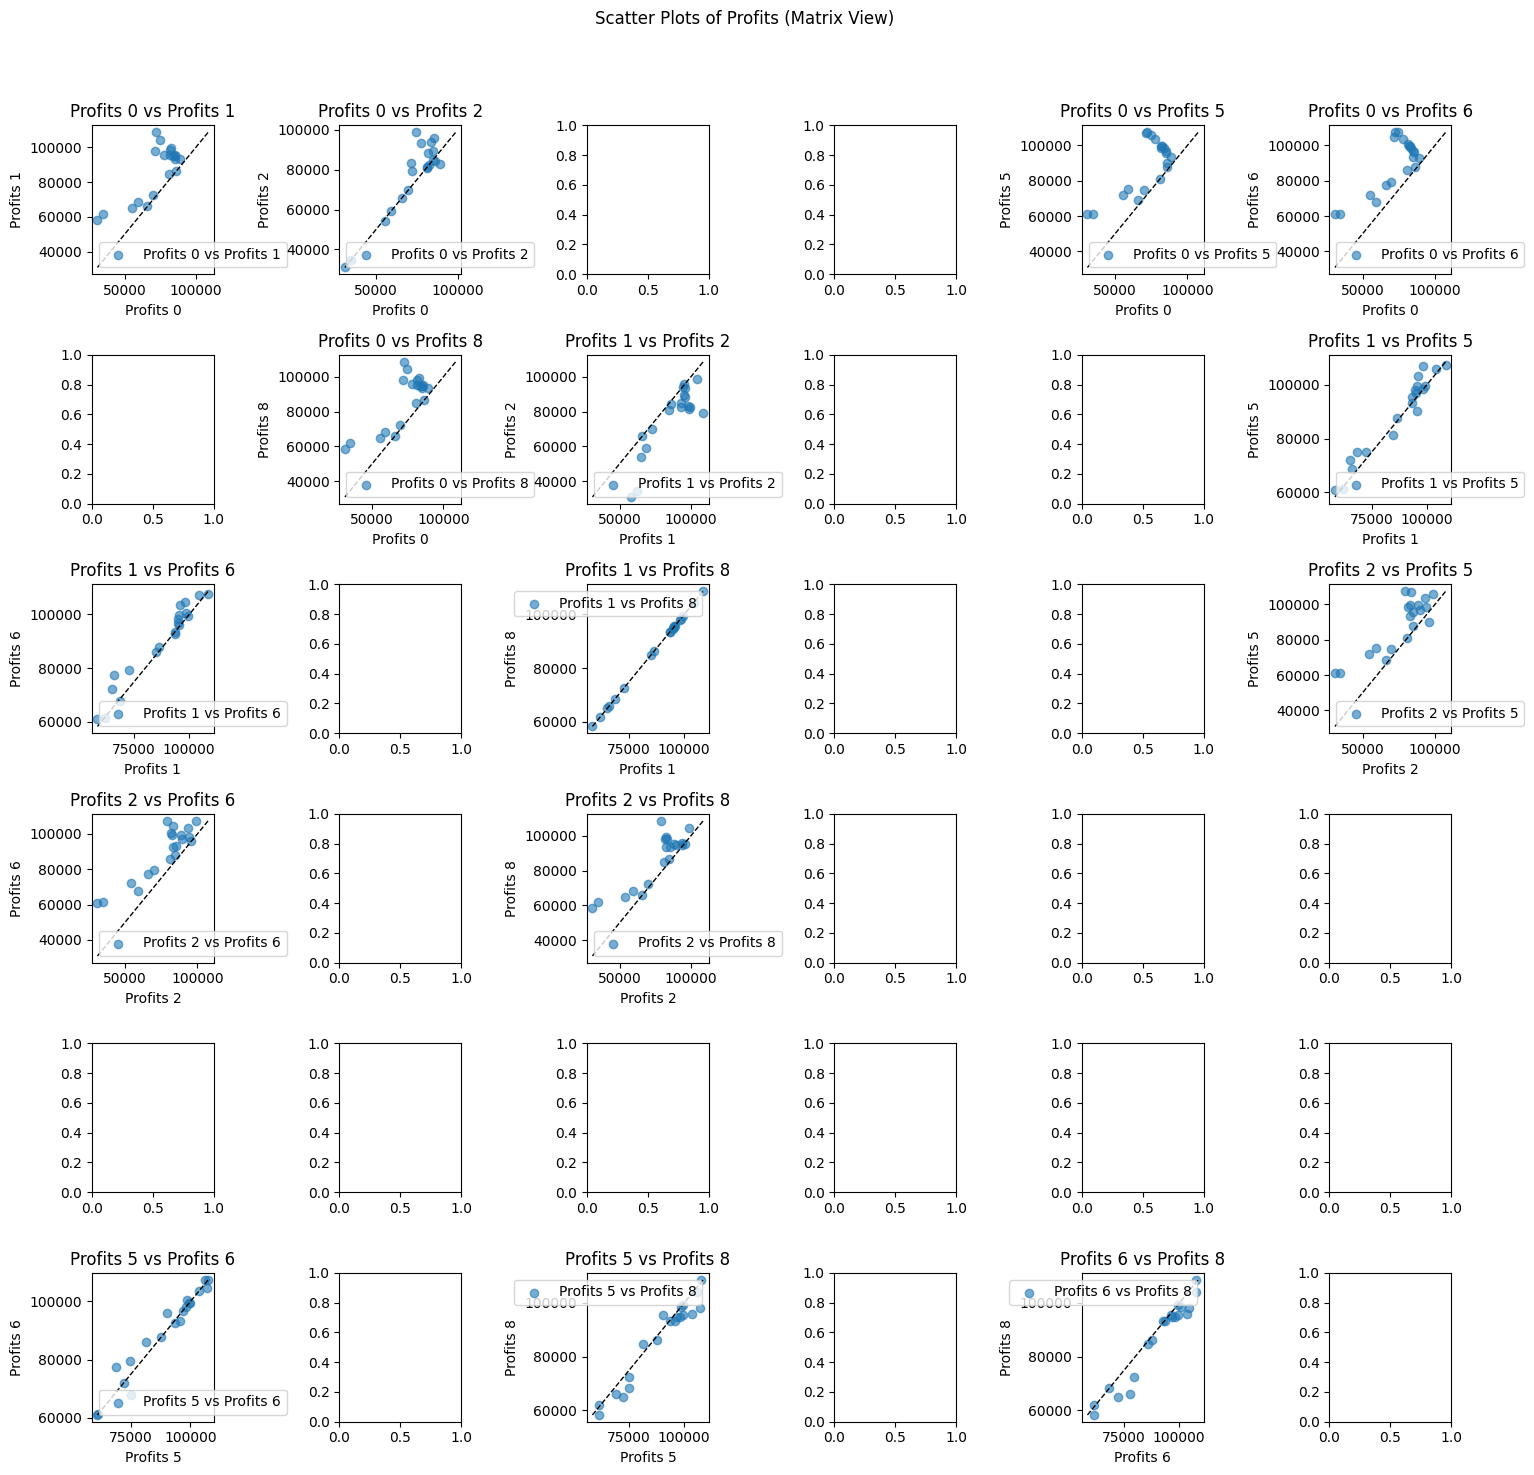

In [ ]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_40_S1_202411271120.png


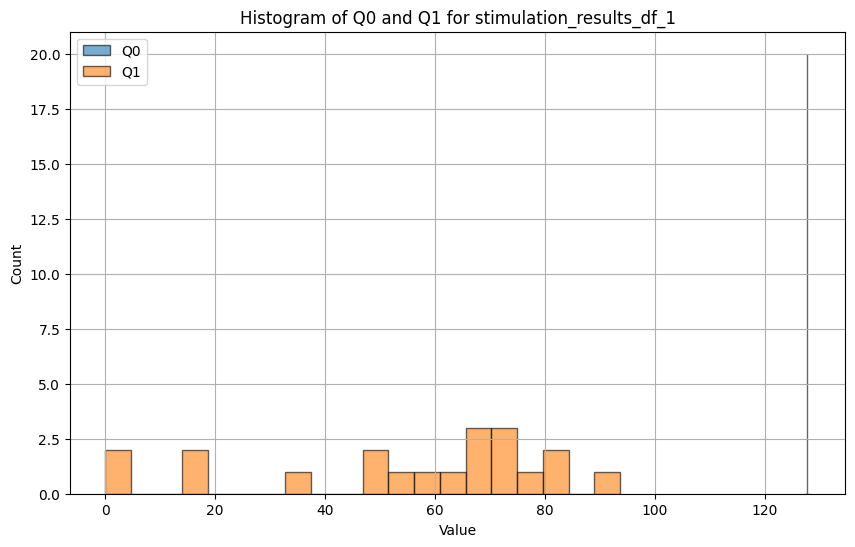

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_40_S2_202411271120.png


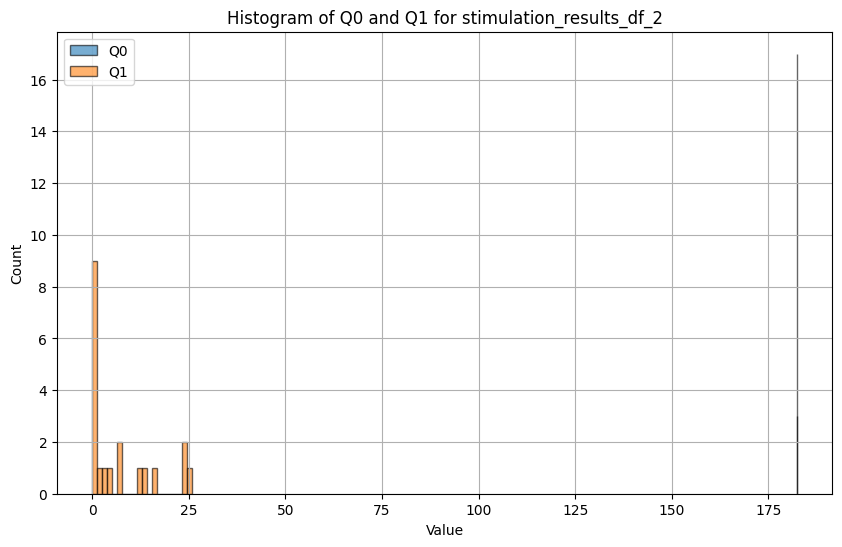

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_40_S5_202411271120.png


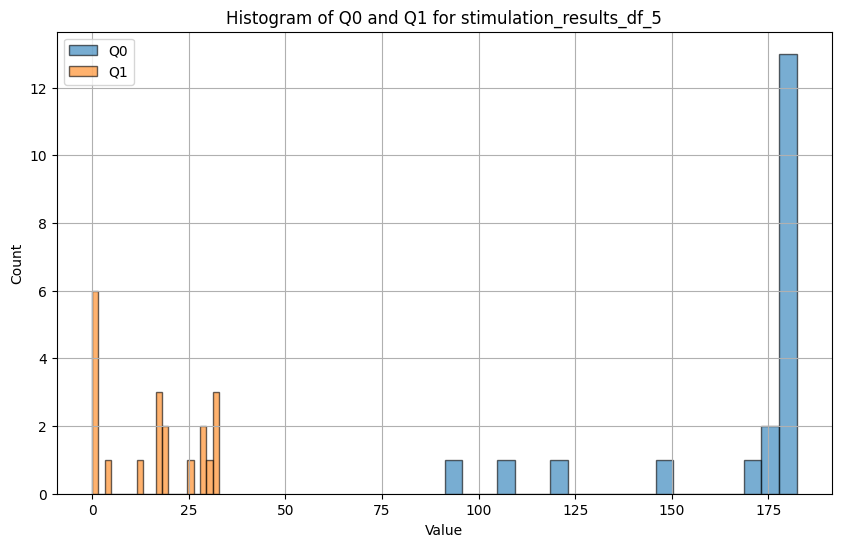

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_40_S6_202411271120.png


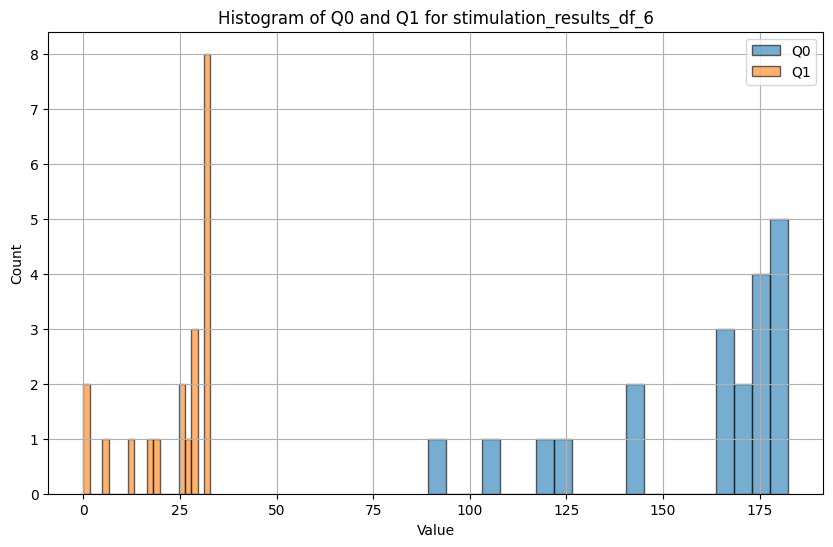

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_40_S8_202411271120.png


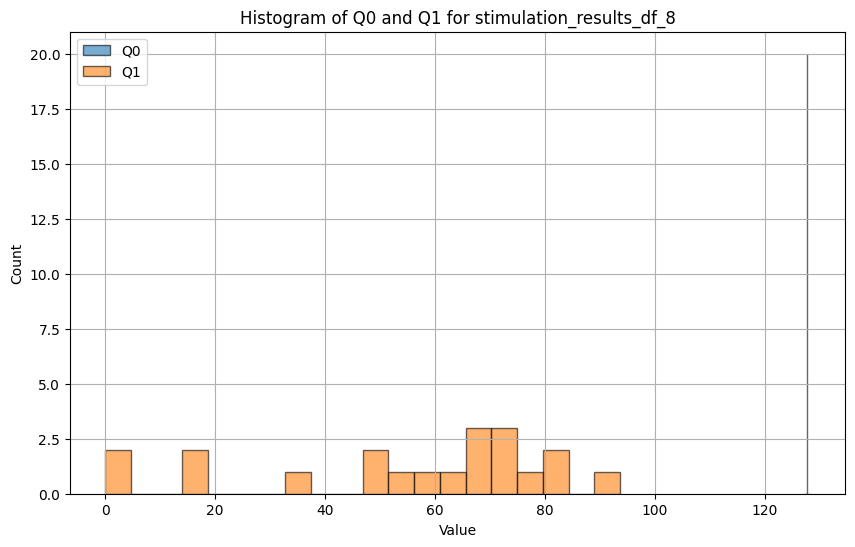

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_40_S1_202411271120.png


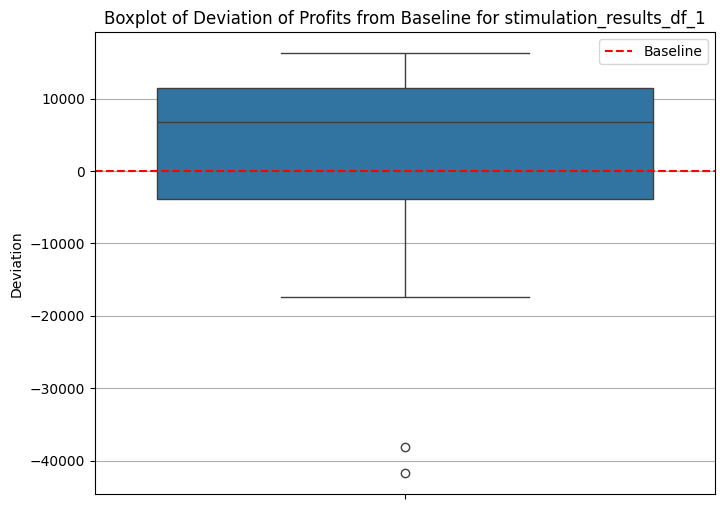

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_40_S2_202411271120.png


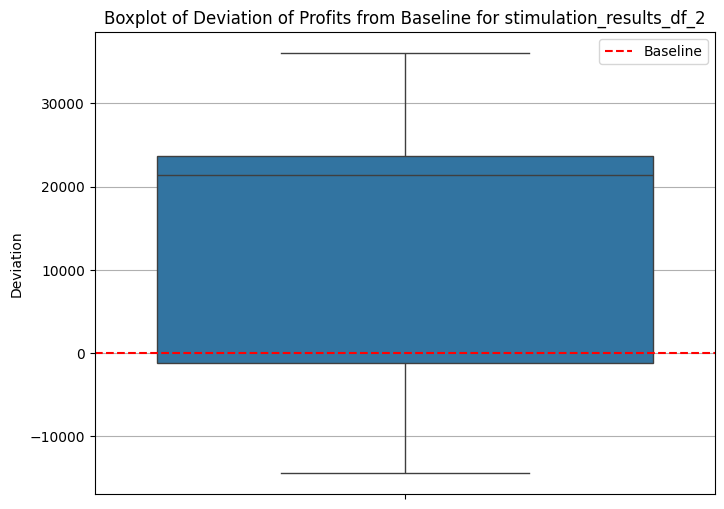

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_40_S3_202411271120.png


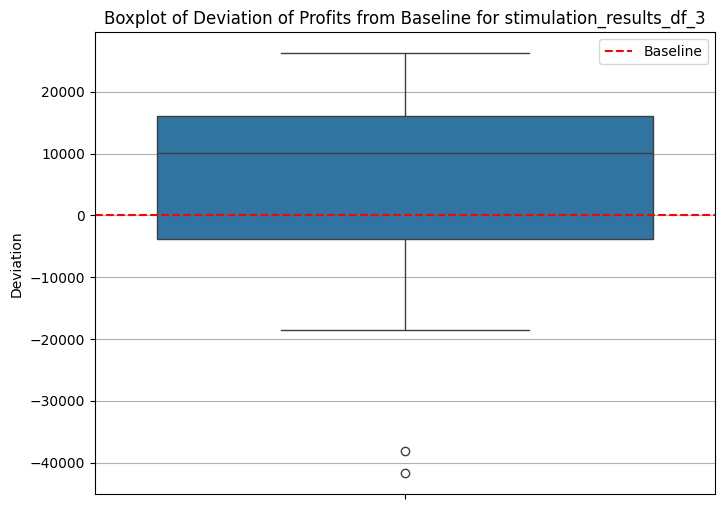

Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_40_S6_202411271120.png


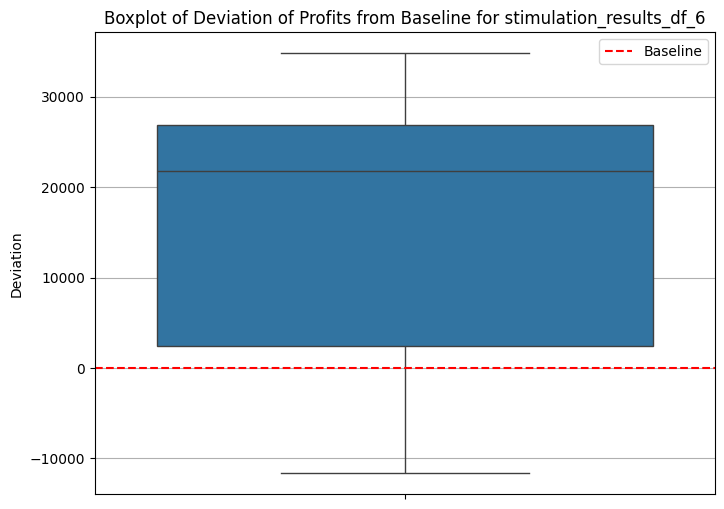

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_40_S7_202411271120.png


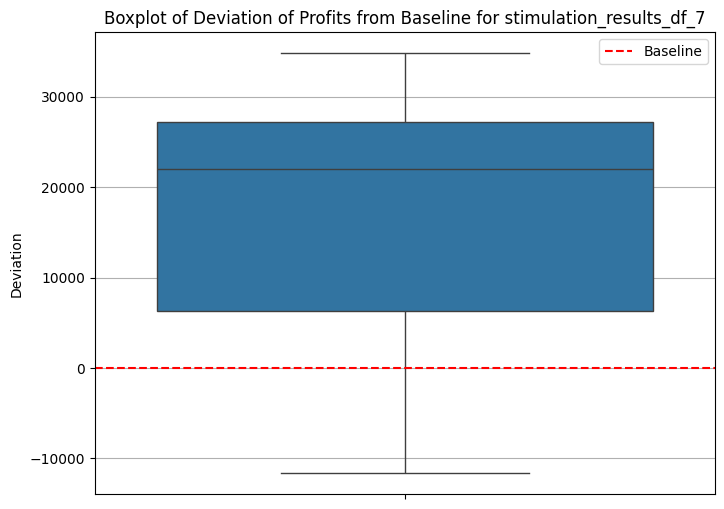

Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_40_S9_202411271120.png


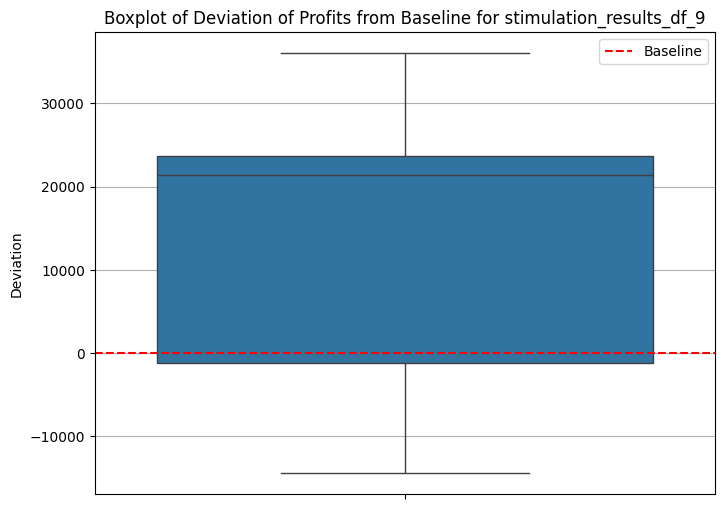

In [ ]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 72674.63967636268
S1's profit: 86755.77424978417
S2's profit: 76734.48197139922
S3's profit: -1
S4's profit: -1
S5's profit: 88913.72814680019
S6's profit: 89650.65817810992
S7's profit: -1
S8's profit: 86755.77424978417
Plot saved as plots/plot_relative_profit_deviation_train_linear_constraint_med_with_holding_cost_0_40_202411271120.png


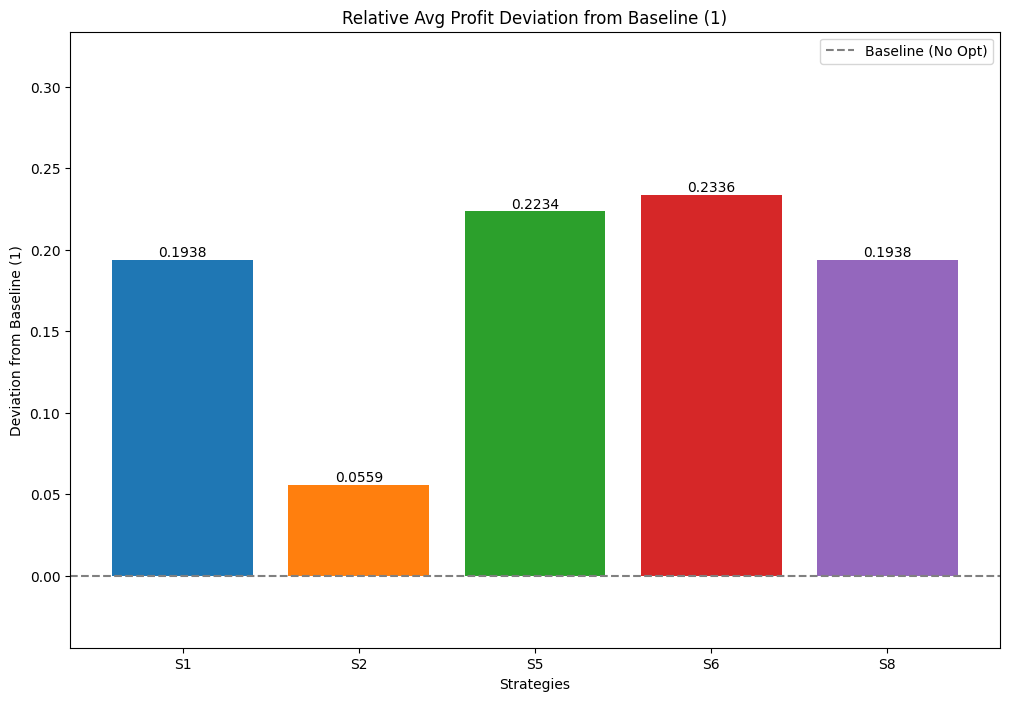

In [ ]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [ ]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [ ]:
status = "test"

In [ ]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 182.363547616305
std of sum: 29.77151112345516
50.0 percentile of sum: 182.363547616305
Q_star: 182.363547616305


In [ ]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (20, 8)


Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  182.506509  186.152352  186.155445  197.501589  195.308833  192.971956   
1  193.043952  189.945391  189.928943  197.378870  195.533094  207.126007   
2  176.671362  172.613954  172.614387  171.613885  174.712906  173.482150   
3  187.639247  182.833828  182.817372  171.967947  173.777413  158.579337   
4  143.921342  146.060975  146.066237  165.376478  180.911710  171.468777   

    Qk_hat_k8   Qk_hat_k9  
0  183.980141  167.998634  
1  201.669752  205.841229  
2  164.228278  177.364577  
3  152.227931  128.669679  
4  170.513673  177.904182

### Run all the strategies


Baseline

In [ ]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/20 with initial inventory Q_star=182.363547616305
--------------------------------------------------
Day 1
Demand      : 19.685536845507485
Sales       : 19.685536845507485
Loss        : 0
Left        : 162.67801077079753
Inventory   : 162.67801077079753
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 22.204846596276745
Sales       : 22.204846596276745
Loss        : 0
Left        : 140.47316417452078
Inventory   : 140.47316417452078
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 21.091220431510656
Sales       : 21.091220431510656
Loss        : 0
Left        : 119.38194374301011
Inventory   : 119.38194374301011
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 23.113494754275063
Sales       : 23.1134

In [ ]:
test_stimulation_df_baseline.head()

losses      lefts  operation_profits       profits
0   0.000000  13.745307       84309.120520  77436.467232
1  16.927085   0.000000       91181.773808  82718.231140
2   4.821038   0.000000       91181.773808  88771.254910
3   0.000000  51.295700       65533.923664  39886.073520
4   0.000000  12.691743       84835.902363  78490.030917

S1

In [ ]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.7000000000000001, R: 7
Q_star 為 182.363547616305
期初庫存 Q0: 127.65448333141352
重新估計量 Qk_hat: 192.97195558273864
訂貨量 Q1 為 65.31747225132513

第一階段：期初庫存 Q0: 127.65448333141352，需求量為 115.58002797215659，Sold_0 為 115.58002797215659，Left_0 為 12.07445535925693，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 77.39192761058206，需求量為 53.038213068429314，Sold_1 為 53.038213068429314，Left_1 為 24.353714542152744，Lost_1 為 0

統計結果：Sold 為 168.6182410405859, Lost 為 0 Left_Penalty_Cost 為 12176.857271076373，Lost_Penalty_Cost 為 0，Profit 為 72132.26324921659
----------------------------------------
這是第 2 筆模擬資料

F: 0.7000000000000001, R: 7
Q_star 為 182.363547616305
期初庫存 Q0: 127.65448333141352
重新估計量 Qk_hat: 207.12600732794454
訂貨量 Q1 為 79.47152399653102

第一階段：期初庫存 Q0: 127.65448333141352，需求量為 124.52876908953297，Sold_0 為 124.52876908953297，Left_0 為 3.1257142418805444，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 82.59723823841156，需求量為 74.76186386346109，Sold_1 為 74.76186386346109，Left_1 為 7.835374374950476，Lost_1 為 0

統計結果：So

R(T)    F                                                 Q0  \
0     7  0.7  [127.65448333141352, 127.65448333141352, 127.6...   

                                                  Q1  average_profits  \
0  [65.31747225132513, 79.47152399653102, 45.8276...     80885.529103   

   average_losses  average_lefts  average_operation_profits  
0        6.145302       6.604305               87260.332756

S2

In [ ]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_2

assigned_R: 3


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/3758896648.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     79551.391107   9991.761471   9991.761471   

                                   alpha_values  R(T)  
0  [0.8838223148726989, 0.0, 9.785315808654634]     5

S3

In [ ]:
# results_df_3.head()

In [ ]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    print(f"betas: {betas}")
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_3

In [ ]:
test_stimulation_results_df_3

S4

In [ ]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_4

In [ ]:
# import numpy as np

# # Provided data
# betas = np.array(
#     [
#         [0.00000000e00, 0.00000000e00, -8.94906903e-02],
#         [-3.13562128e-02, 4.00627944e-03, -6.21189321e-02],
#         [3.97911689e-02, 1.78930917e-02, -4.96275009e-02],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [3.50517907e-05, 1.43159496e-03, -3.20821046e-03],
#     ]
# )
# X_data = np.array([1.4397189210284136, -0.794923445271338, 1])

# # Initialization
# features_num = len(X_data)
# tau_vars = np.zeros((1, len(betas)))  # Assuming one data point for simplicity
# exp_tau_vars = np.zeros_like(tau_vars)
# r_vars = np.zeros_like(tau_vars)
# R_vars = np.zeros_like(tau_vars)

# # Calculate tau_vars
# for k in range(len(betas)):
#     tau_vars[0, k] = sum(X_data[j] * betas[k, j] for j in range(features_num))

# # Step 2: Calculate the exponentials of -tau_vars
# exp_tau_vars[0] = np.exp(-tau_vars[0])

# # Step 3: Softmax normalization
# sum_exp_tau = np.sum(exp_tau_vars[0])  # Sum of exponentials for normalization
# r_vars[0] = exp_tau_vars[0] / sum_exp_tau  # Normalize to get softmax

# # Step 4: Find the index of the maximum r_var and set R_vars
# max_r_index = np.argmax(r_vars[0])
# R_vars[0, max_r_index] = 1

# print(f"tau_vars: {tau_vars}")
# print(f"exp_tau_vars: {exp_tau_vars}")
# print(f"r_vars: {r_vars}")
# print(f"R_vars: {R_vars}")

# # Print the final R matrix
# print("Final R matrix:")
# print(R_vars)

In [ ]:
test_stimulation_results_df_4

S5

In [ ]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_5

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/2289234698.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     79365.244226   5173.379873   5173.379873   

                                   alpha_values  \
0  [2.3891108458838857, 0.0, 5.236864687473501]   

                                         beta_balues  
0  [[-5.725955835676227], [-5.72595586668971], [-...

In [ ]:
test_stimulation_results_df_5

F  R(T)      Sold_0     Left_0     Lost_0     Sold_1     Left_1  \
0   0.981417     9  139.736662  39.238074   0.000000  28.881579  10.356494   
1   0.999829     9  162.818466  19.513985   0.000000  36.472167   6.550596   
2   0.996286     9  140.309691  41.376535   0.000000  41.376535   0.000000   
3   0.973974     9  108.594943  69.022394   0.000000  22.472904  46.549490   
4   0.999065     9  127.318805  54.874299   0.000000  42.353000  12.521299   
5   0.635860     9  102.457245  13.500492   0.000000  14.080121   2.612478   
6   0.989192     9  165.062413  15.330077   0.000000  18.378358   4.663691   
7   0.989857     9  126.546138  53.967629   0.000000  15.633275  38.334354   
8   0.998943     9  140.392942  41.777767   0.000000  60.562623   0.000000   
9   0.971815     9  164.124310  13.099364   0.000000  44.563773   5.886903   
10  0.999768     9  137.767370  44.553818   0.000000  60.702186   0.000000   
11  0.995454     9  136.933615  44.600889   0.000000  48.715871   0.707976   
12  0.995425     9  140.241683  41.287532   0.000000  46.489557   3.060692   
13  0.994798     9  172.815844   8.599036   0.000000  37.423036   4.918483   
14  0.997461     9  140.913937  40.986607   0.000000  40.986607   0.000000   
15  0.897828     9  163.731061   0.000000   2.778138  28.482182   5.579105   
16  0.483769     9   88.221772   0.000000   5.725948  38.219010   5.173748   
17  0.487019     9   88.814433   0.000000  70.694928  16.880427  70.198938   
18  0.995220     9  149.820091  31.671718   0.000000  35.275314   0.000000   
19  0.999805     9  182.327915   0.000000  10.346760  45.850200   0.452745   

      Lost_1        profits          Q0         Q1         hc0        hc1  
0   0.000000   79130.873324  178.974735   0.000000  872.851236  24.797284  
1   0.000000   96370.018595  182.332452  23.508777  901.420857  24.786679  
2   5.498360   88093.932860  181.686226   0.000000  892.251041  20.688267  
3   0.000000   42259.178684  177.617337   0.000000  986.558924  57.785942  
4   0.000000   78575.252835  182.193104   0.000000  948.269612  33.697799  
5   0.000000   56962.443849  115.957737   3.192107  530.601345   9.652539  
6   0.000000   89388.539419  180.392489   7.711972  813.738152  13.852870  
7   0.000000   51922.529603  180.513767   0.000000  937.925582  46.150991  
8   1.549155   99703.204840  182.170709  18.784856  970.933329  30.281312  
9   0.000000  101400.589896  177.223674  37.351312  910.697399  28.168789  
10  7.545019   95462.268442  182.321188  16.148368  972.093497  30.351093  
11  0.000000   92470.755169  181.534504   4.822958  923.833403  25.065911  
12  0.000000   91835.273824  181.529215   8.262717  924.317854  26.305470  
13  0.000000  102660.198341  181.414880  33.742484  895.025599  23.630002  
14  4.797960   88551.292000  181.900544   0.000000  891.548601  20.493303  
15  0.000000   91928.000094  163.731061  34.061287  791.169393  19.820196  
16  0.000000   57770.543360   88.221772  43.392758  526.458122  24.283253  
17  0.000000  -17599.503000   88.814433  87.079364  703.575188  78.639151  
18  1.635031   91730.187331  181.491809   3.603596  867.068492  17.637657  
19  0.000000  108689.305063  182.327915  46.302945  914.523443  23.377845

S6

In [ ]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_98712/492182808.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     76862.715595  21333.132014  21333.132014   

                                        alpha_values  \
0  [1.061532339774418, 0.1852969302635481, 2.6695...   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [ ]:
test_stimulation_results_df_6

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0   0.907740     2  19.685537  145.853159     0.0  148.932704  13.888267   
1   0.982885     2  24.854172  154.388148     0.0  168.189780   0.000000   
2   0.943666     2  16.823387  155.266949     0.0  159.847975   0.000000   
3   0.894748     2  22.203155  140.966206     0.0  108.864693  56.571400   
4   0.972504     2   0.759442  176.589797     0.0  168.912363   7.677435   
5   0.609350     2  12.588876   98.534442     0.0  103.948490  51.500979   
6   0.934047     2  23.029999  147.306089     0.0  160.410771   5.884188   
7   0.917991     2   6.528274  160.879755     0.0  135.651139  25.228616   
8   0.969001     2  20.621332  156.089124     0.0  163.793008   0.000000   
9   0.849015     2  22.686542  132.142916     0.0  165.938201   0.000000   
10  0.979613     2  19.894873  158.750876     0.0  163.038415   0.000000   
11  0.924886     2  15.657551  153.007903     0.0  158.636989   0.000000   
12  0.928331     2  17.036042  152.257609     0.0  160.068867   0.000000   
13  0.947117     2  40.349247  132.370373     0.0  169.889633  14.395320   
14  0.943902     2  14.498904  157.634394     0.0  157.634394   0.000000   
15  0.845653     2  29.375034  124.841299     0.0  165.616348   7.269379   
16  0.634077     2   3.999698  111.632750     0.0  128.167032  18.360614   
17  0.622136     2  21.131018   92.323986     0.0  155.258769   9.063664   
18  0.933958     2  17.697115  152.622762     0.0  160.755542   0.000000   
19  0.983590     2  26.234768  153.136214     0.0  169.623843   0.000000   

       Lost_1       profits          Q0         Q1         hc0         hc1  
0    0.000000  77364.986790  165.538696  16.967812  164.179834  706.836956  
1    6.246680  93398.635994  179.242320  13.801633  173.716050  672.759120  
2   10.513224  83079.069021  172.090336   4.581026  165.969155  639.391900  
3    0.000000  37248.223761  163.169360  24.469887  164.302726  888.029970  
4    0.000000  80997.185042  177.349239   0.000000  176.969518  737.068927  
5    0.000000  32518.193477  111.123318  56.915027  133.286394  827.801791  
6    0.000000  88778.290871  170.336088  18.988871  168.315523  688.716591  
7    0.000000  58475.398482  167.408029   0.000000  164.143892  744.433485  
8   18.090380  83161.980209  176.710456   7.703884  170.251732  655.172034  
9   20.063340  84280.701712  154.829458  33.795285  160.383830  663.752804  
10  23.081287  79926.000628  178.645749   4.287539  170.842082  652.153661  
11  11.354946  81469.797096  168.665454   5.629086  163.651222  634.547955  
12   9.626331  83739.289201  169.293652   7.811257  164.681259  640.275466  
13   0.000000  97921.779905  172.719619  51.914581  178.502287  794.721096  
14  14.565205  78784.047011  172.133299   0.000000  164.883846  630.537578  
15   0.000000  93861.001102  154.216333  48.044428  163.551030  720.620427  
16   0.000000  56903.057952  115.632448  34.894896  131.080047  659.553039  
17   0.000000  83663.061285  113.455004  71.998447  138.888719  693.544391  
18   8.277779  85087.438878  170.319877   8.132780  165.537709  643.022166  
19  42.666264  76596.173493  179.370981  16.487630  174.497412  678.495374

S7

In [ ]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_7

S8

In [ ]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

R(T)    F                                                 Q0  \
0     7  0.7  [127.65448333141352, 127.65448333141352, 127.6...   

                                                  Q1  average_profits  \
0  [65.31747225132513, 79.47152399653102, 45.8276...     80885.529103   

   average_losses  average_lefts  average_operation_profits  
0        6.145302       6.604305               87260.332756

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_linear_constraint_med_with_holding_cost_0_40_202411271120.png


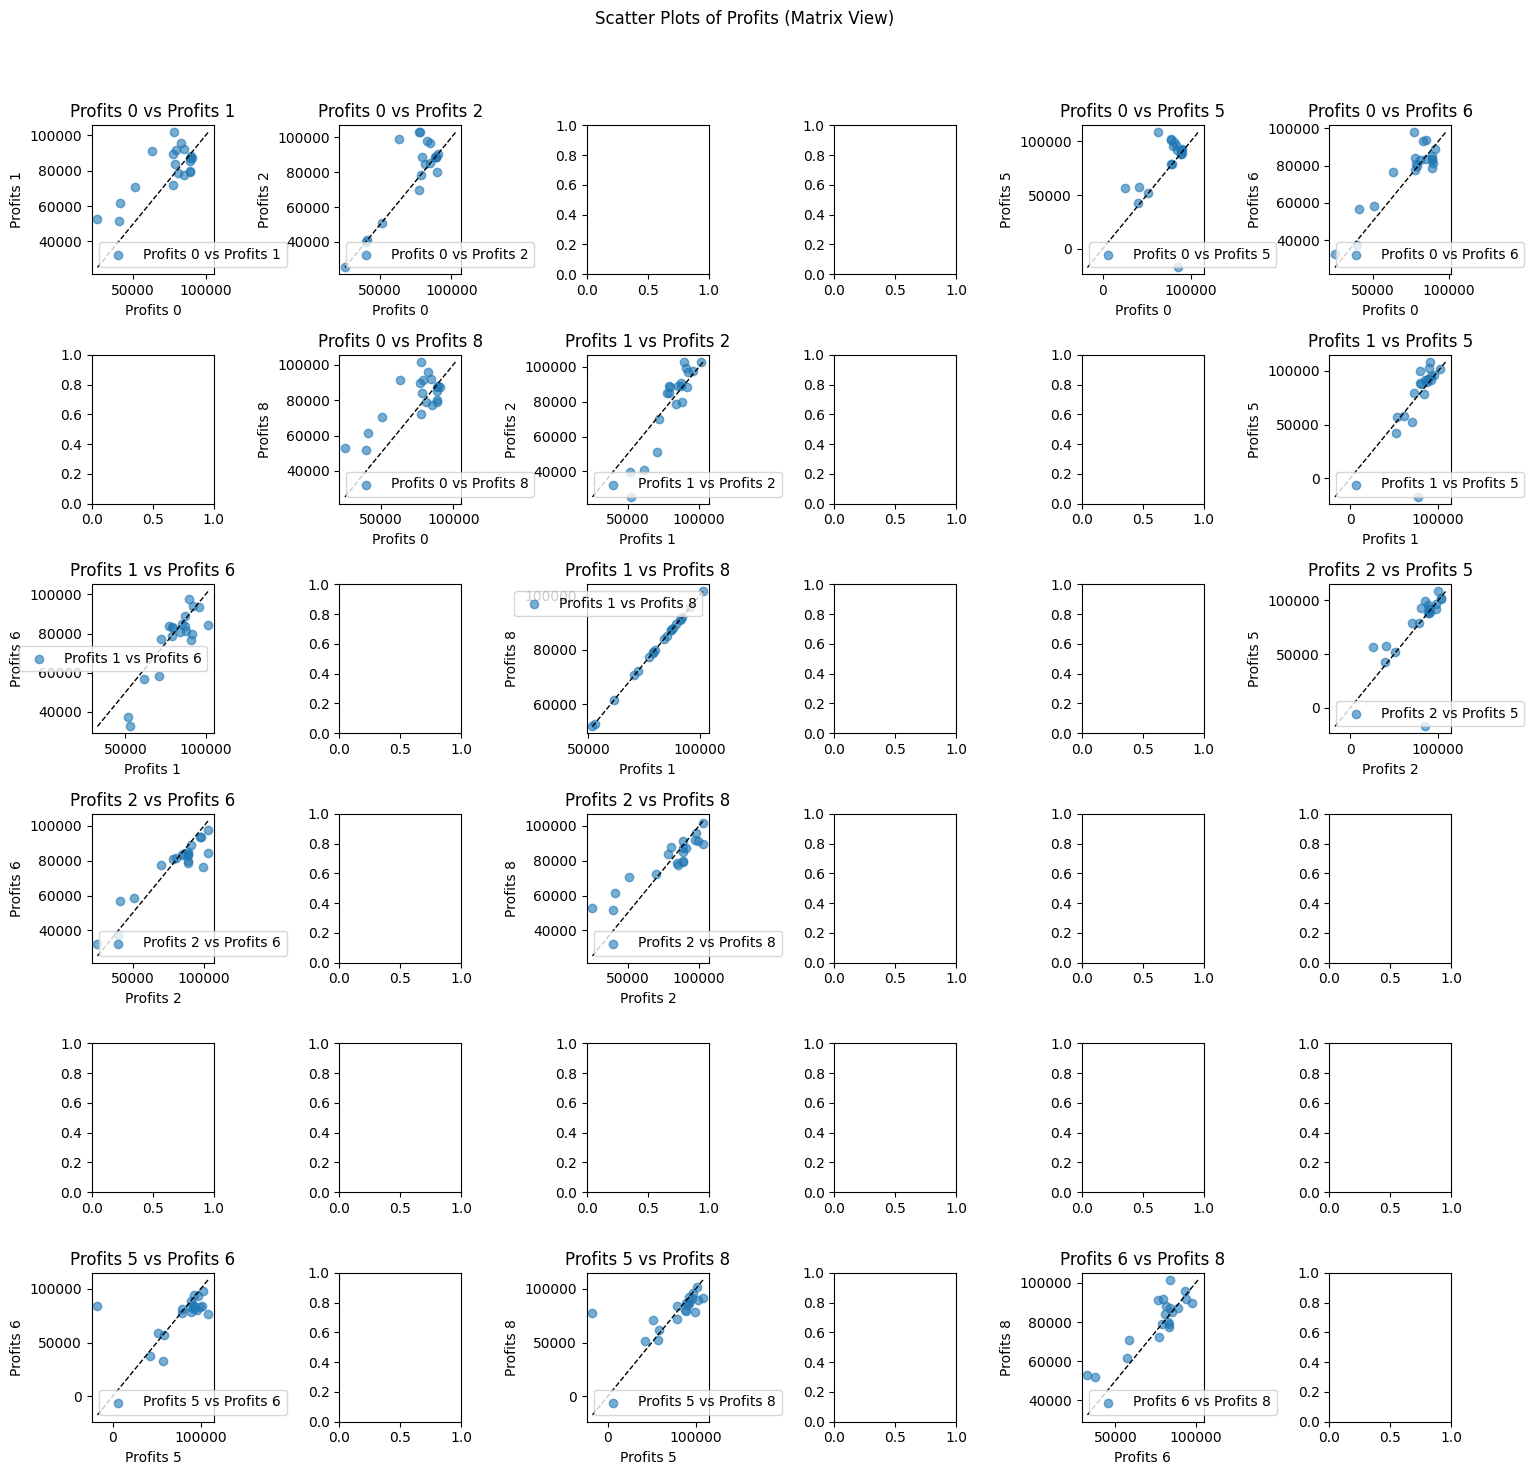

In [ ]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 74037.04036463043
S1's profit: 80885.52910343371
S2's profit: 79551.39110650046
S3's profit: -1
S4's profit: -1
S5's profit: 79365.24422642618
S6's profit: 76862.71559545145
S7's profit: -1
S8's profit: 80885.52910343371
Plot saved as plots/plot_relative_profit_deviation_test_linear_constraint_med_with_holding_cost_0_40_202411271120.png


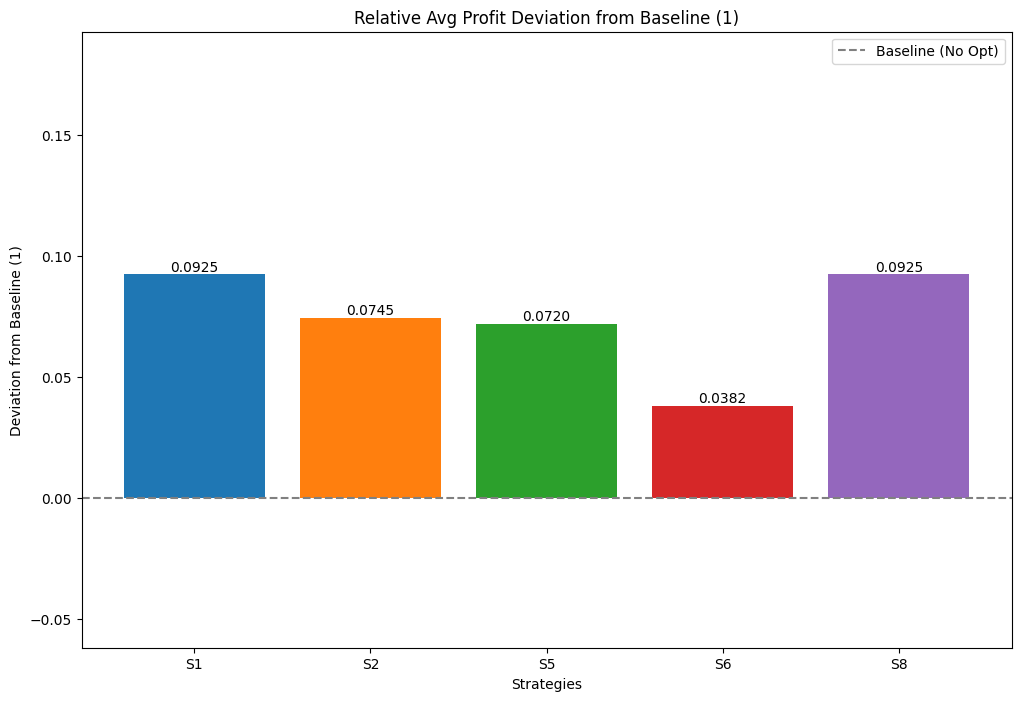

In [ ]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_40_S1_202411271120.png


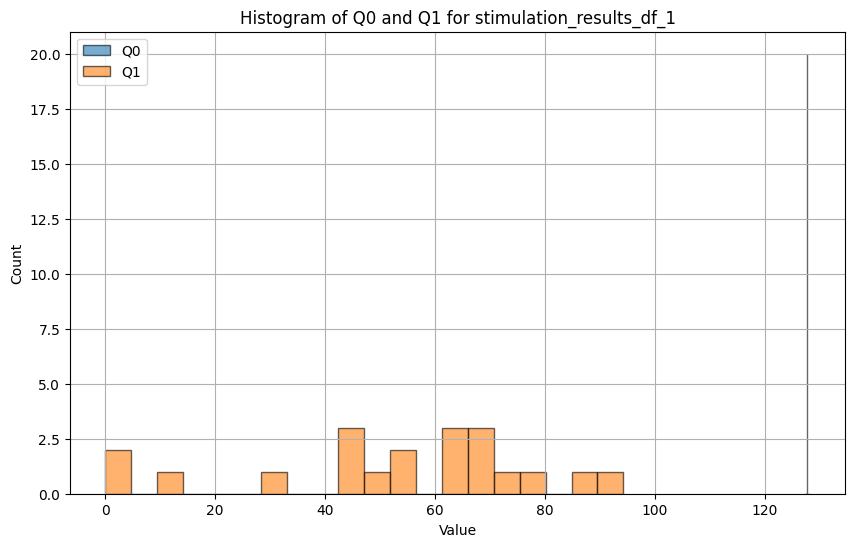

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_40_S2_202411271120.png


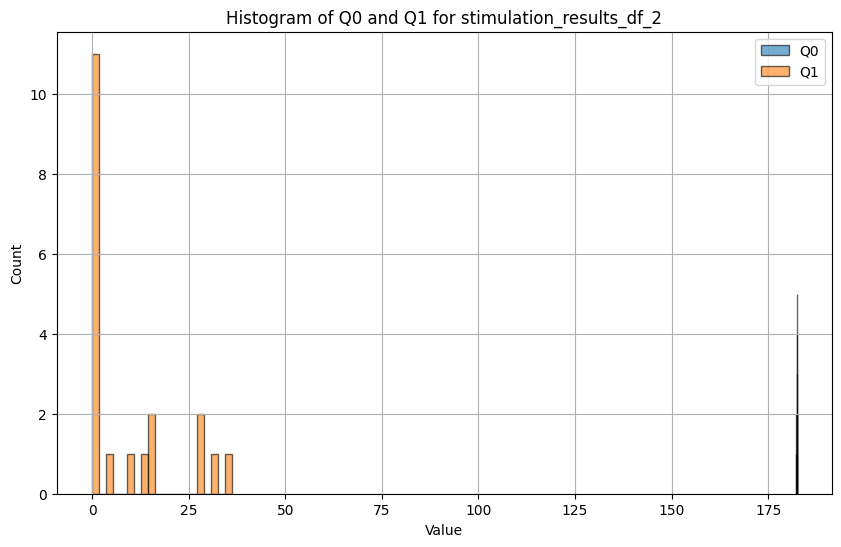

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_40_S5_202411271120.png


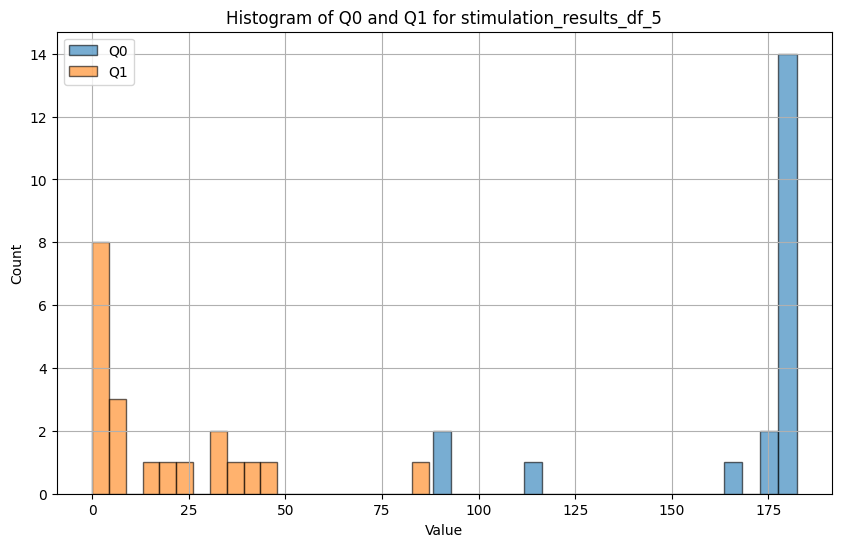

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_40_S6_202411271120.png


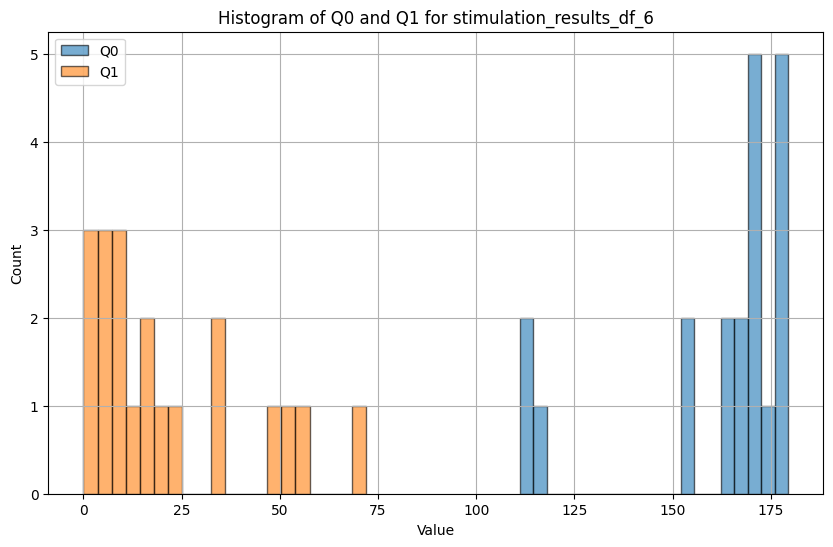

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_40_S8_202411271120.png


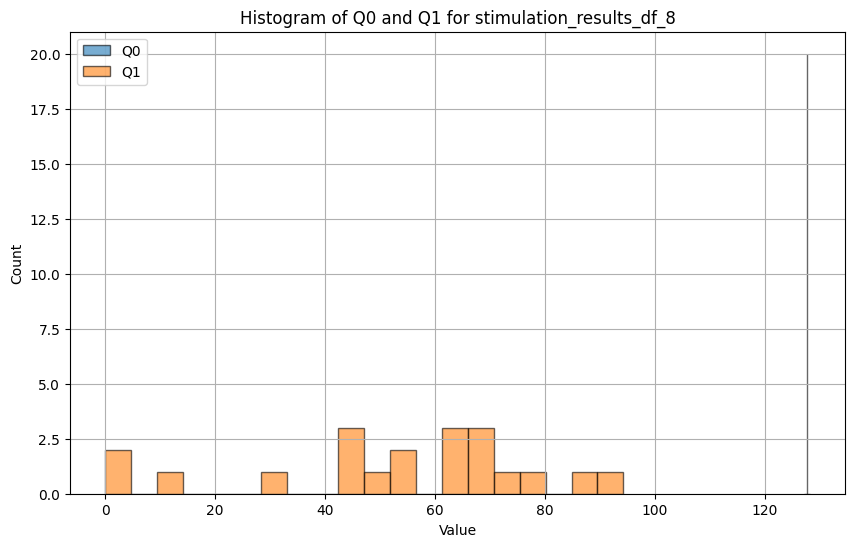

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_40_S1_202411271120.png


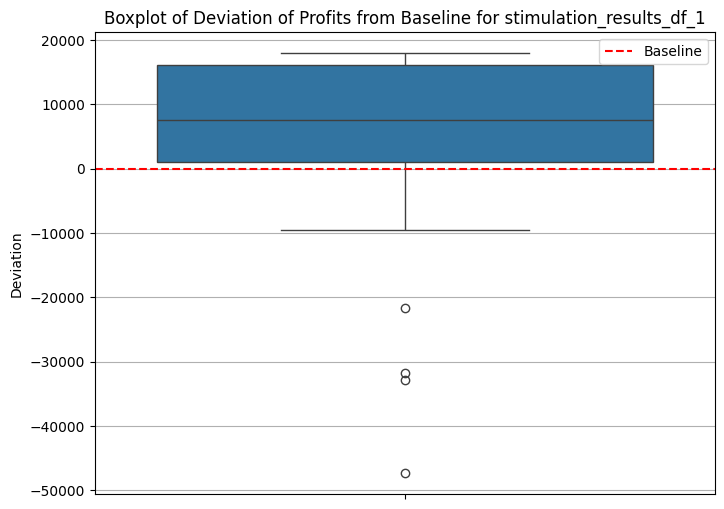

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_40_S2_202411271120.png


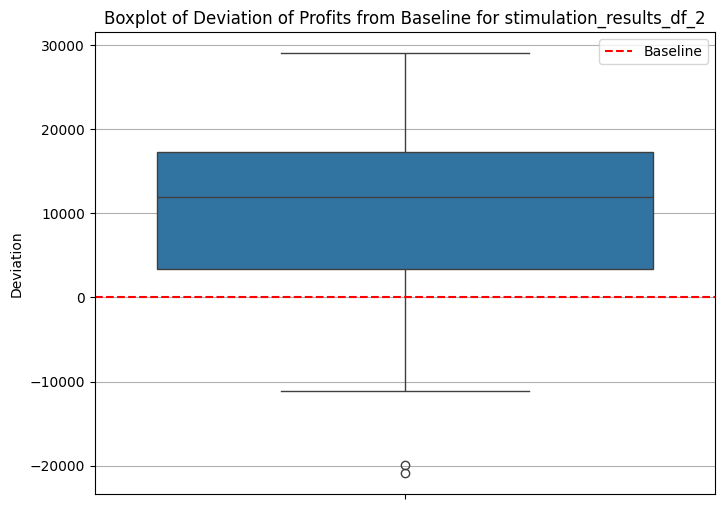

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_40_S3_202411271120.png


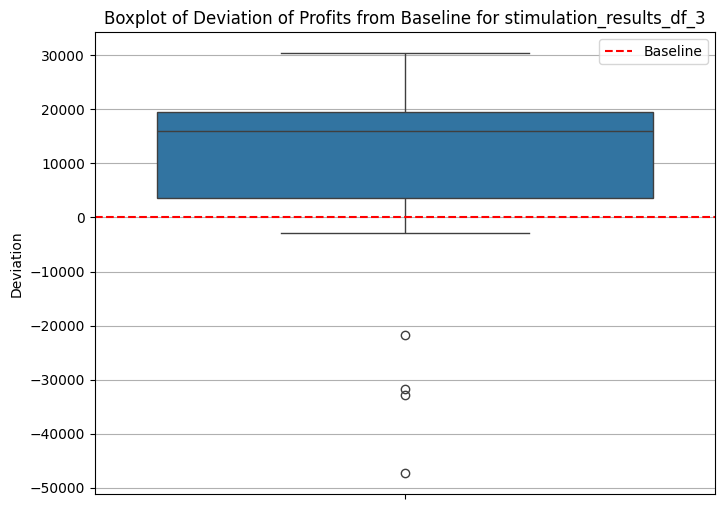

Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_40_S6_202411271120.png


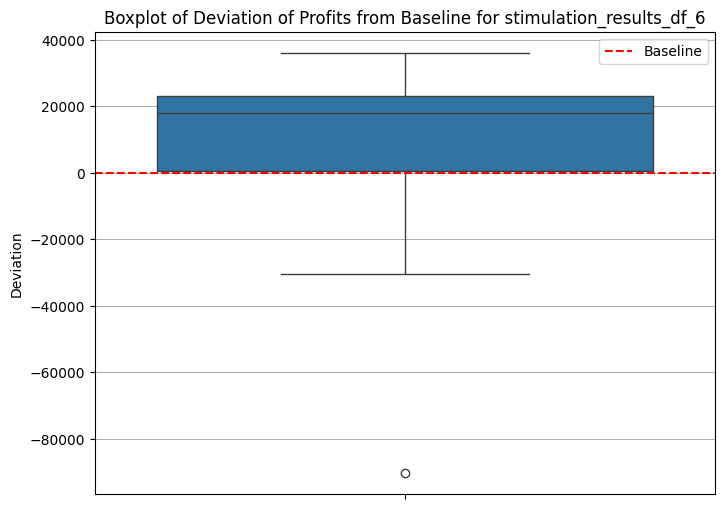

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_40_S7_202411271120.png


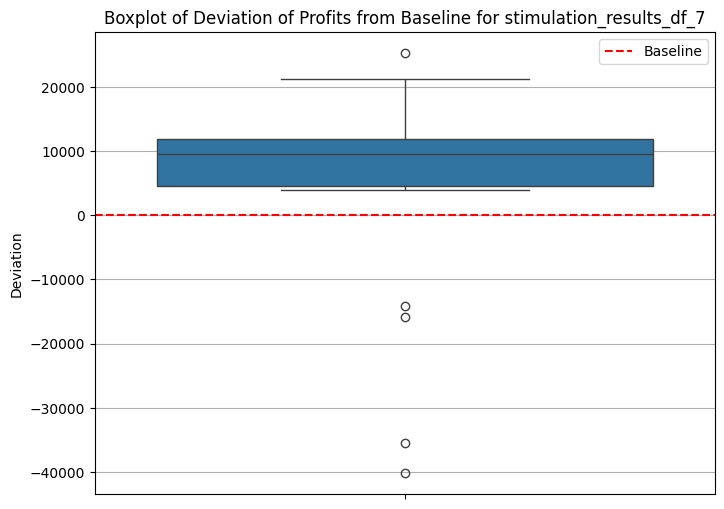

Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_40_S9_202411271120.png


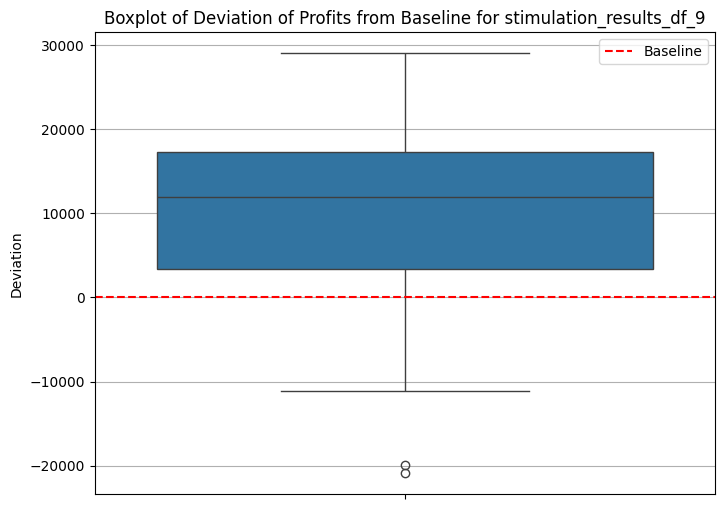

In [ ]:
plot_profits_deviation_box_plot(f"{status}_{model_prefix}", dfs, baseline_avg_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_linear_constraint_med_with_holding_cost_0_40_202411271120.png


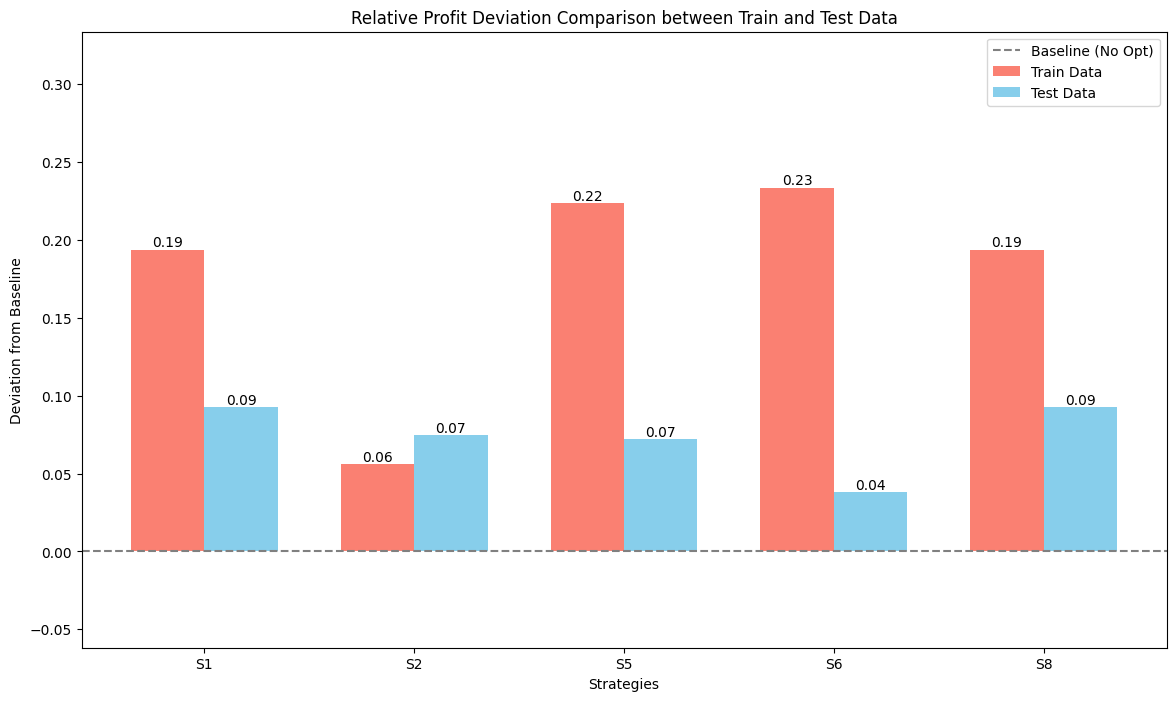

In [ ]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

因為 baseline 的 hc 計算是低估的，所以通常其他的策略會比較低是正常的。

因此可以看 S8 的表現來進行相對性的評估會比較正確。

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [ ]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]

In [ ]:
# # 測試 HC 與 最佳 R, F 的變化

# def visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits):
#     plt.figure(figsize=(15, 10))

#     # Plot R changes
#     plt.subplot(3, 1, 1)
#     plt.plot(holding_cost_list, best_Rs, marker="o", label="Best R")
#     plt.title("HC vs. Best R(T)")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("R(T)")
#     plt.grid(True)
#     plt.legend()

#     # Plot F changes
#     plt.subplot(3, 1, 2)
#     plt.plot(holding_cost_list, best_Fs, marker="o", color="orange", label="Best F")
#     plt.title("HC vs. Best F")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.legend()

#     # Plot profits
#     plt.subplot(3, 1, 3)
#     plt.plot(
#         holding_cost_list,
#         best_profits,
#         marker="o",
#         color="green",
#         label="Average Profits",
#     )
#     plt.title("HC vs. Average Profits")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("Average Profits")
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# holding_cost_list = [x for x in range(0, 1050, 50)]
# margins = [
#     {
#         "type": "low",
#         "price": 1000,
#         "cost": 800,
#         "salvage_value": 0,
#     },
#     {
#         "type": "med",
#         "price": 1000,
#         "cost": 500,
#         "salvage_value": 0,
#     },
#     {
#         "type": "high",
#         "price": 1000,
#         "cost": 200,
#         "salvage_value": 0,
#     },
# ]

# for margin in margins:

#     price = margin["price"]
#     cost = margin["cost"]
#     salvage_value = margin["salvage_value"]

#     service_lv = calculate_service_level(
#         salvage_value=salvage_value, cost=cost, price=price
#     )
#     Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)

#     best_Rs = []
#     best_Fs = []
#     best_profits = []

#     for holding_cost in holding_cost_list:

#         results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#             assigned_Ts=ASSIGNED_TS,
#             assigned_Fs=ASSIGNED_FS,
#             cost=cost,
#             price=price,
#             salvage_value=salvage_value,
#             Qk_hat_df=Qk_hat_df_train,
#             demand_df_train=demand_df_train,
#             Q_star=Q_star,
#             holding_cost=holding_cost,
#         )

#         best_Rs.append(results_df_8.iloc[0]["R(T)"])
#         best_Fs.append(results_df_8.iloc[0]["F"])
#         best_profits.append(results_df_8.iloc[0]["average_profits"])

#     print(f"Now at {margin['type']}...\n")
#     visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits)